# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:06<00:00, 8.98KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

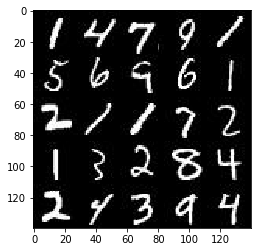

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

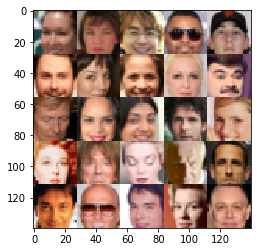

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [38]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='input_z')

    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/demo/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/demo/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/demo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", 

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [47]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    # "As we are using Batch Normalization, there is no need to use dropouts. 
    # However if we wish to use dropouts we should do proper testing keeping 
    # different values of keep_prob between 0.6 and 0.9."
    #keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        relu1 = tf.maximum(alpha * x1, x1)
        #28x28x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #dp2 = tf.nn.dropout(relu2, keep_prob)
        #14x14x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #dp3 = tf.nn.dropout(relu3, keep_prob)
        #14x14x128
        
        x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #dp4 = tf.nn.dropout(relu4, keep_prob)
        #7x7x256
                        
        flat = tf.reshape(relu4, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #1

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [48]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #reuse_param=True 
    alpha = 0.1
    # "As we are using Batch Normalization, there is no need to use dropouts. 
    # However if we wish to use dropouts we should do proper testing keeping 
    # different values of keep_prob between 0.6 and 0.9."
    #keep_prob = 0.8
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #dp2 = tf.nn.dropout(x2, keep_prob)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #dp3 = tf.nn.dropout(x3, keep_prob)
        # 14x14x64 now
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #dp4 = tf.nn.dropout(x4, keep_prob)
        # 28x28x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
   
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # scaling the batch images by a factor of 2 to make it in the range of [-1 1]
                batch_images = batch_images * 2
                steps+=1
        
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                # run the optimization for the generator twice to make sure that the discriminator loss does not go to zero.
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr:learning_rate, input_real:batch_images})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr:learning_rate, input_real:batch_images})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.4885... Generator Loss: 0.0039


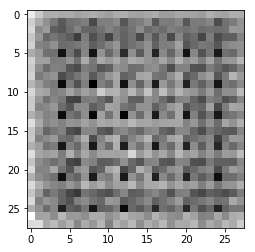

Epoch 1/2... Discriminator Loss: 3.7304... Generator Loss: 0.0692


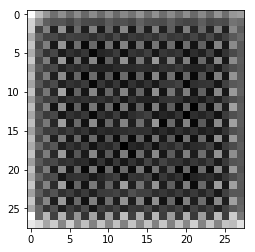

Epoch 1/2... Discriminator Loss: 3.1829... Generator Loss: 0.0816


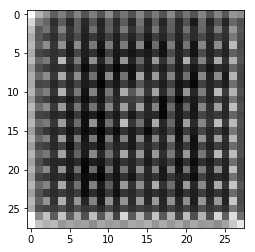

Epoch 1/2... Discriminator Loss: 2.6308... Generator Loss: 0.1347


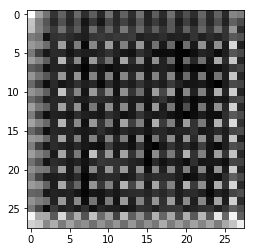

Epoch 1/2... Discriminator Loss: 2.4669... Generator Loss: 0.1568


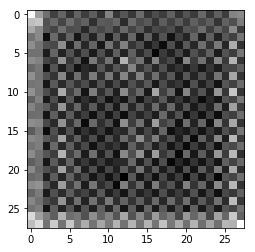

Epoch 1/2... Discriminator Loss: 2.6000... Generator Loss: 0.1377


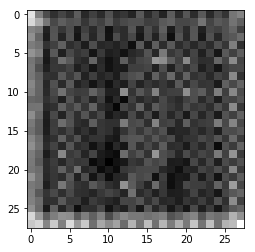

Epoch 1/2... Discriminator Loss: 2.3526... Generator Loss: 0.1726


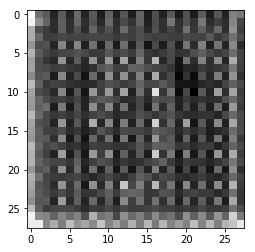

Epoch 1/2... Discriminator Loss: 2.3484... Generator Loss: 0.1700


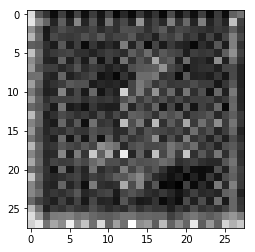

Epoch 1/2... Discriminator Loss: 2.2423... Generator Loss: 0.1948


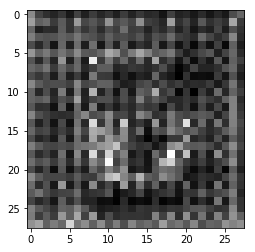

Epoch 1/2... Discriminator Loss: 2.6262... Generator Loss: 0.1230


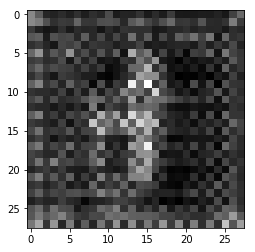

Epoch 1/2... Discriminator Loss: 2.2360... Generator Loss: 0.1934


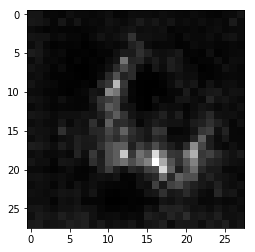

Epoch 1/2... Discriminator Loss: 2.1403... Generator Loss: 0.2241


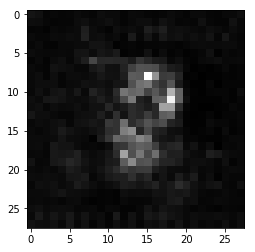

Epoch 1/2... Discriminator Loss: 2.2430... Generator Loss: 0.1791


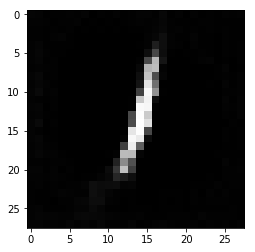

Epoch 1/2... Discriminator Loss: 2.2083... Generator Loss: 0.1977


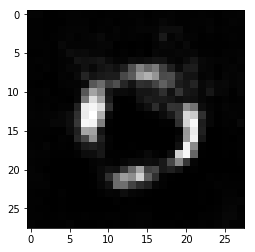

Epoch 1/2... Discriminator Loss: 2.1051... Generator Loss: 0.2457


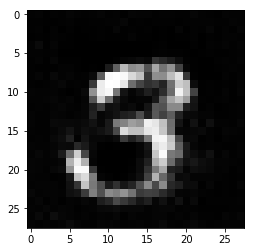

Epoch 1/2... Discriminator Loss: 1.8451... Generator Loss: 0.2880


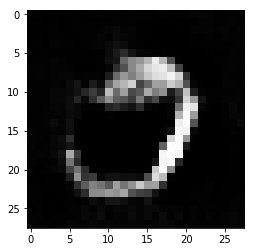

Epoch 1/2... Discriminator Loss: 2.1816... Generator Loss: 0.2198


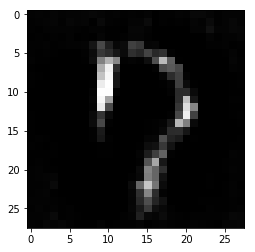

Epoch 1/2... Discriminator Loss: 2.0459... Generator Loss: 0.2375


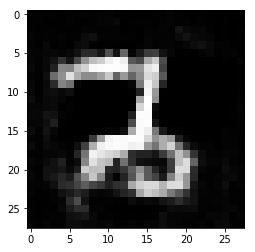

Epoch 1/2... Discriminator Loss: 1.9557... Generator Loss: 0.2590


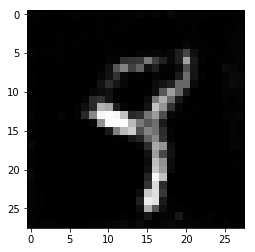

Epoch 1/2... Discriminator Loss: 2.1309... Generator Loss: 0.1990


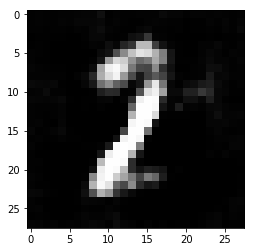

Epoch 1/2... Discriminator Loss: 1.7239... Generator Loss: 0.3547


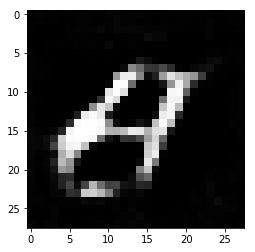

Epoch 1/2... Discriminator Loss: 2.0197... Generator Loss: 1.5448


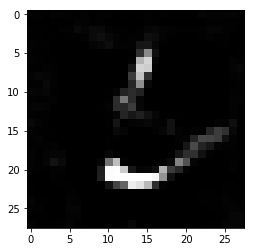

Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.7551


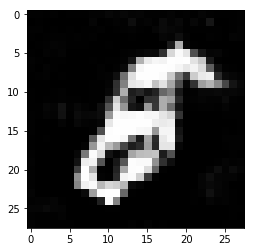

Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.8003


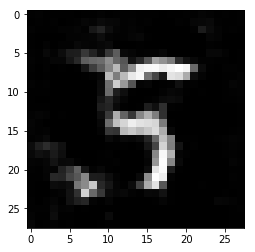

Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.8767


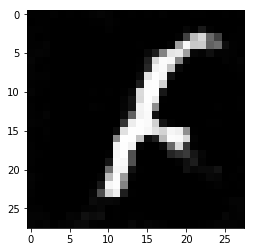

Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.6617


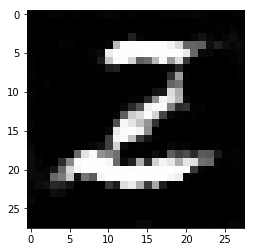

Epoch 1/2... Discriminator Loss: 2.1580... Generator Loss: 1.7081


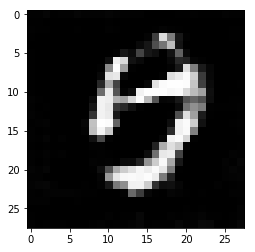

Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.7343


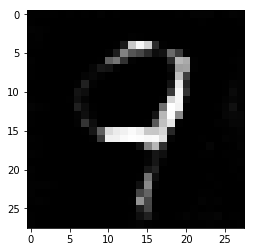

Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.6284


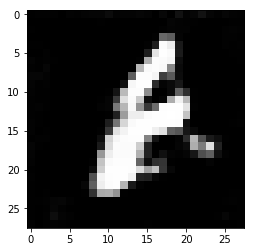

Epoch 1/2... Discriminator Loss: 1.9357... Generator Loss: 0.2587


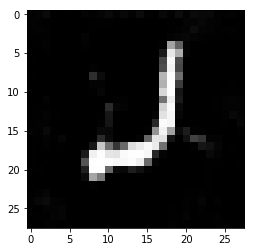

Epoch 1/2... Discriminator Loss: 3.1740... Generator Loss: 2.1494


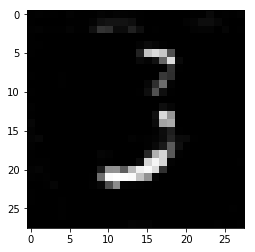

Epoch 1/2... Discriminator Loss: 1.8560... Generator Loss: 0.3027


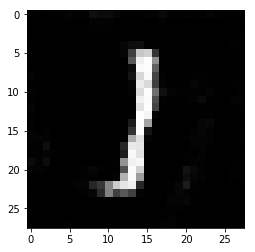

Epoch 1/2... Discriminator Loss: 1.7478... Generator Loss: 1.5917


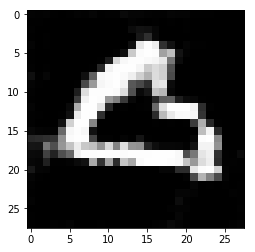

Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.7989


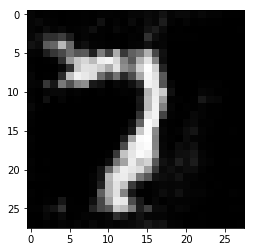

Epoch 1/2... Discriminator Loss: 1.4972... Generator Loss: 0.8940


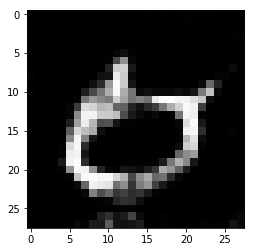

Epoch 1/2... Discriminator Loss: 1.7723... Generator Loss: 0.9819


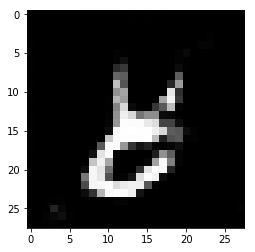

Epoch 1/2... Discriminator Loss: 1.8247... Generator Loss: 0.2884


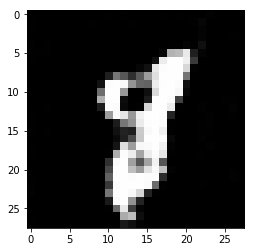

Epoch 1/2... Discriminator Loss: 1.6591... Generator Loss: 0.3936


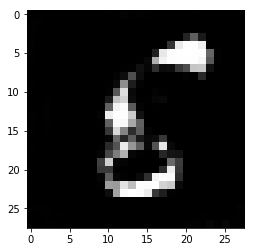

Epoch 1/2... Discriminator Loss: 1.5326... Generator Loss: 0.4927


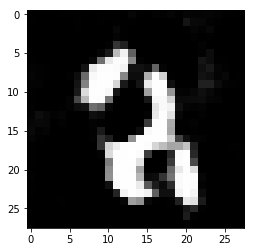

Epoch 1/2... Discriminator Loss: 3.2657... Generator Loss: 0.0693


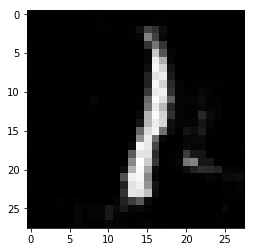

Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 0.4748


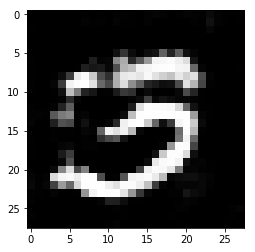

Epoch 1/2... Discriminator Loss: 2.3868... Generator Loss: 0.1618


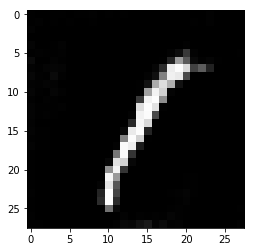

Epoch 1/2... Discriminator Loss: 1.6451... Generator Loss: 0.3977


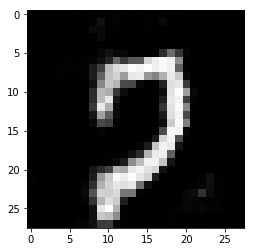

Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.4727


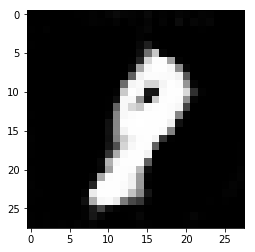

Epoch 1/2... Discriminator Loss: 2.1864... Generator Loss: 0.1982


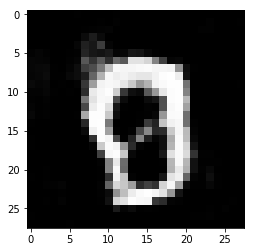

Epoch 1/2... Discriminator Loss: 2.4780... Generator Loss: 0.1655


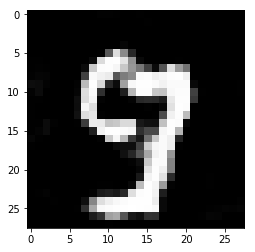

Epoch 1/2... Discriminator Loss: 1.7911... Generator Loss: 0.3156


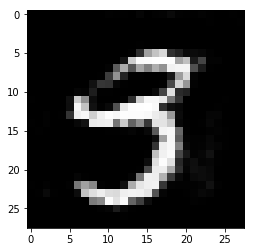

Epoch 1/2... Discriminator Loss: 1.7865... Generator Loss: 0.3252


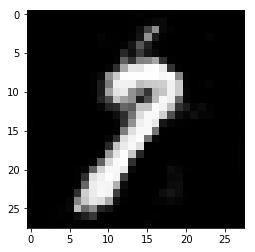

Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 1.5941


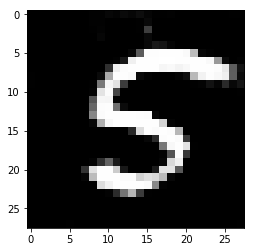

Epoch 1/2... Discriminator Loss: 1.5727... Generator Loss: 1.1338


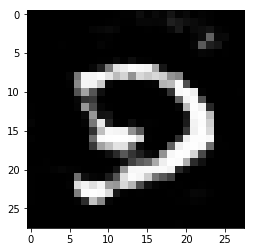

Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.9826


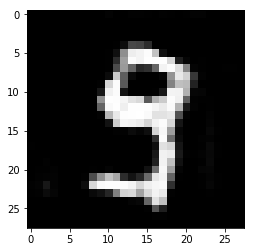

Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.5579


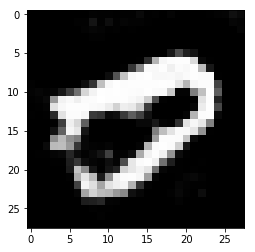

Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.4011


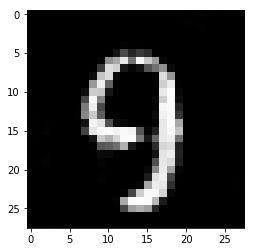

Epoch 1/2... Discriminator Loss: 1.8324... Generator Loss: 1.7782


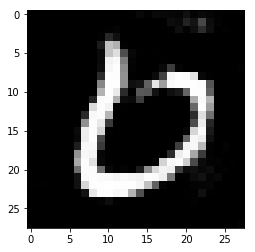

Epoch 1/2... Discriminator Loss: 1.7409... Generator Loss: 0.3217


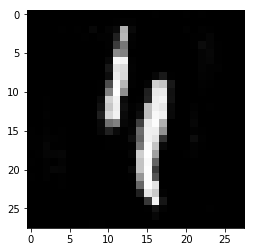

Epoch 1/2... Discriminator Loss: 2.0783... Generator Loss: 0.2389


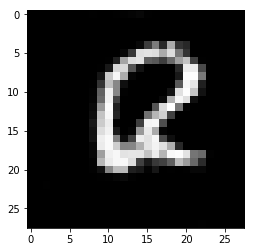

Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.8787


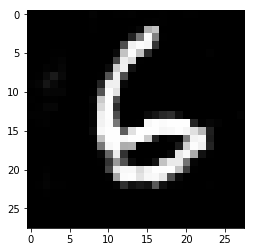

Epoch 1/2... Discriminator Loss: 1.7579... Generator Loss: 1.9386


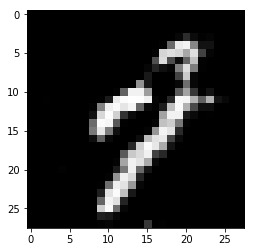

Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.7486


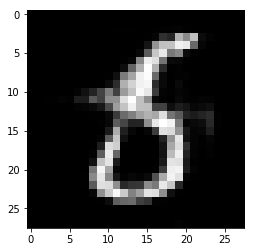

Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 1.1716


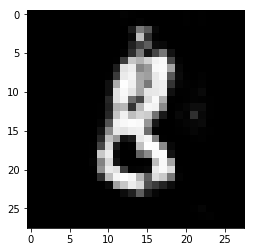

Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.9193


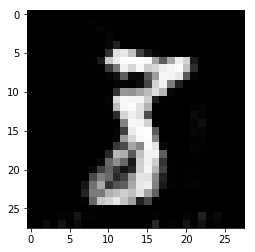

Epoch 1/2... Discriminator Loss: 1.9467... Generator Loss: 0.2576


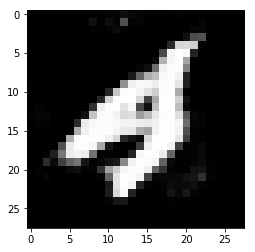

Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 0.4403


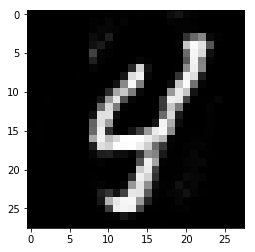

Epoch 1/2... Discriminator Loss: 1.6123... Generator Loss: 1.0865


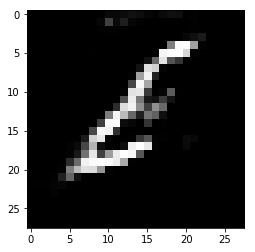

Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 1.1578


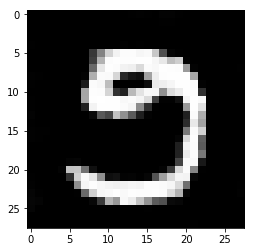

Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 1.3375


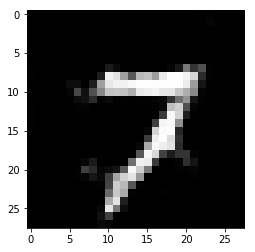

Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6666


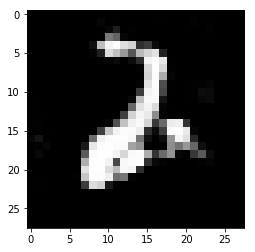

Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.7803


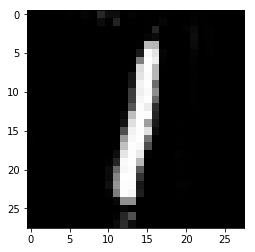

Epoch 1/2... Discriminator Loss: 2.3572... Generator Loss: 1.7972


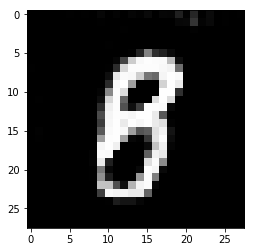

Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 0.9551


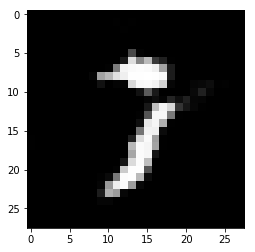

Epoch 1/2... Discriminator Loss: 1.7589... Generator Loss: 0.3399


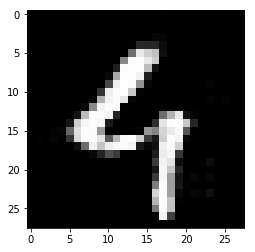

Epoch 1/2... Discriminator Loss: 1.6123... Generator Loss: 0.4128


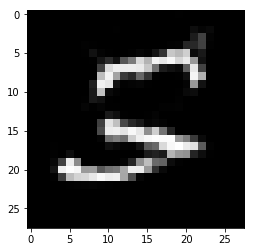

Epoch 1/2... Discriminator Loss: 1.8728... Generator Loss: 0.2900


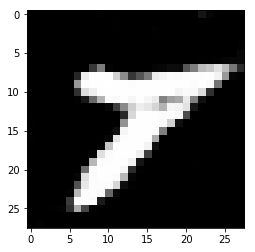

Epoch 1/2... Discriminator Loss: 1.9351... Generator Loss: 0.2748


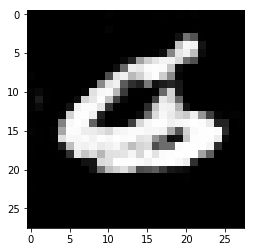

Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.5820


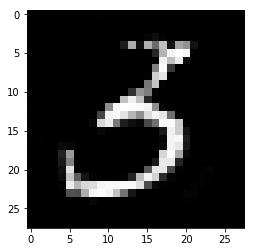

Epoch 1/2... Discriminator Loss: 1.9041... Generator Loss: 2.3076


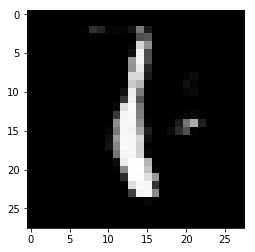

Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 1.0779


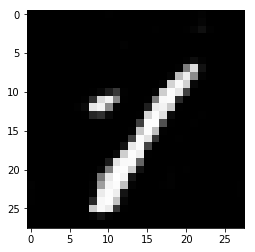

Epoch 1/2... Discriminator Loss: 1.8436... Generator Loss: 0.3165


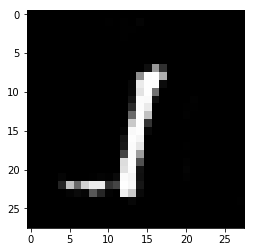

Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.8141


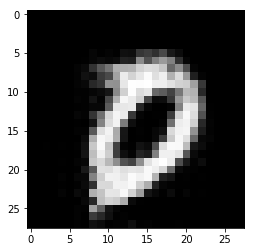

Epoch 1/2... Discriminator Loss: 1.6456... Generator Loss: 0.3708


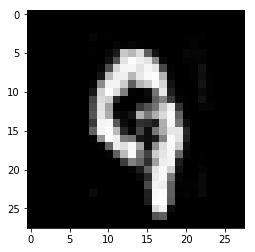

Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.4289


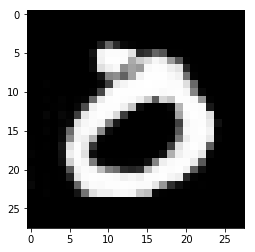

Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.7978


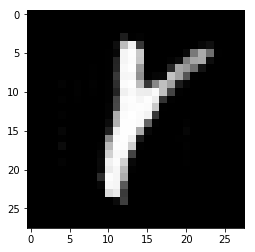

Epoch 1/2... Discriminator Loss: 1.9488... Generator Loss: 0.2636


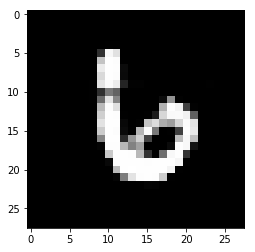

Epoch 1/2... Discriminator Loss: 1.7360... Generator Loss: 0.3788


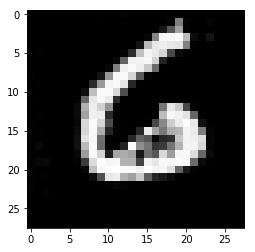

Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 1.3098


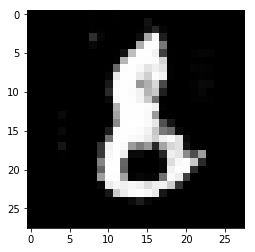

Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 1.2297


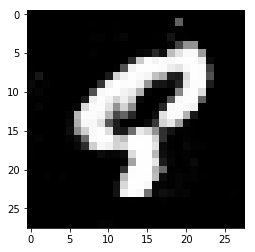

Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 1.0357


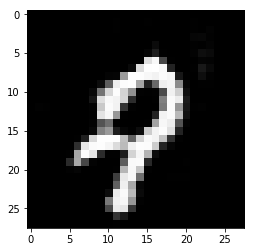

Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 1.2228


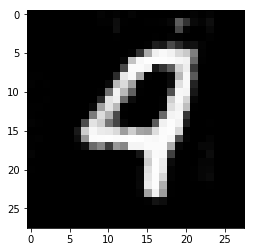

Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 1.5858


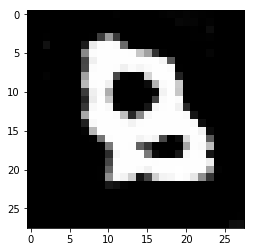

Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.6326


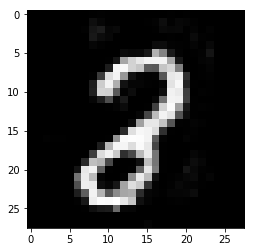

Epoch 1/2... Discriminator Loss: 1.9799... Generator Loss: 0.2954


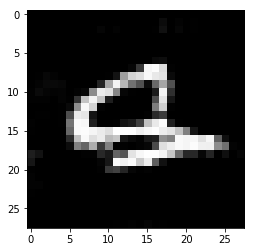

Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 1.3438


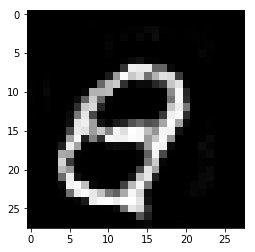

Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.6994


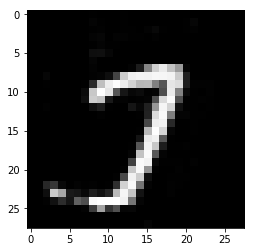

Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.7435


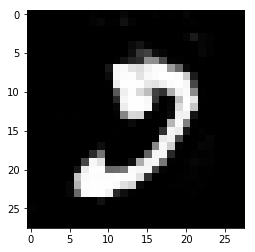

Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.4285


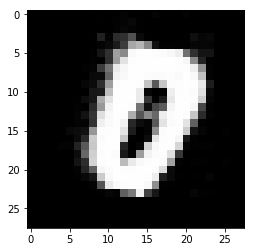

Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.8143


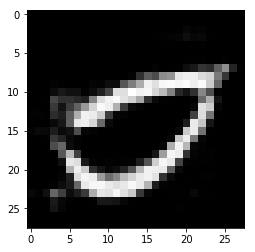

Epoch 2/2... Discriminator Loss: 1.7413... Generator Loss: 0.3322


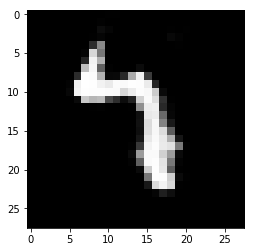

Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5783


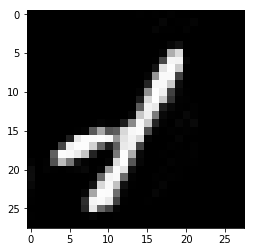

Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.5481


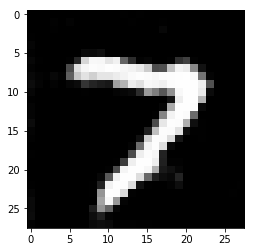

Epoch 2/2... Discriminator Loss: 2.2237... Generator Loss: 0.2100


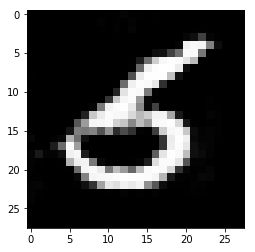

Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.5593


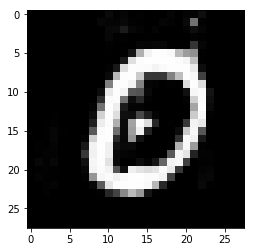

Epoch 2/2... Discriminator Loss: 1.6240... Generator Loss: 0.4030


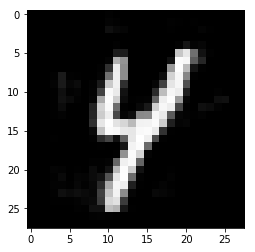

Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 1.4231


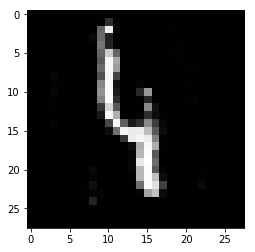

Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 1.3268


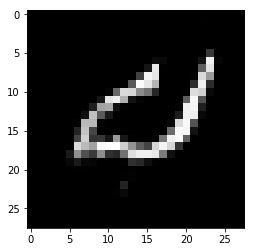

Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 1.3153


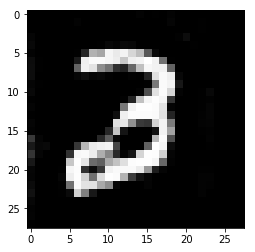

Epoch 2/2... Discriminator Loss: 1.3716... Generator Loss: 1.1522


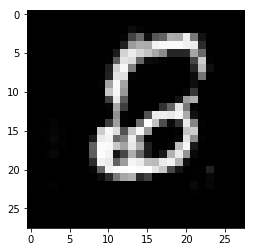

Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 1.7285


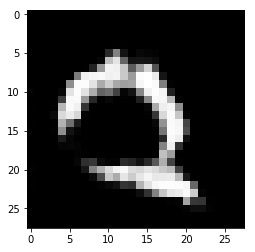

Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 1.7828


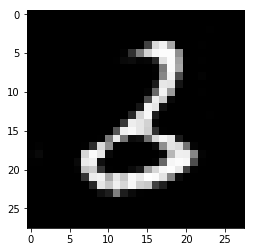

Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 1.2750


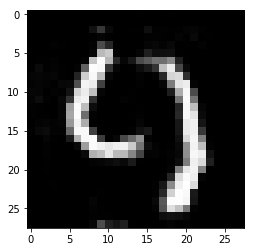

Epoch 2/2... Discriminator Loss: 1.8090... Generator Loss: 0.3342


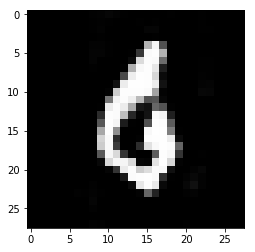

Epoch 2/2... Discriminator Loss: 1.3363... Generator Loss: 0.8935


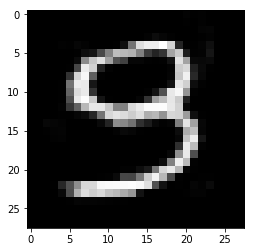

Epoch 2/2... Discriminator Loss: 1.3662... Generator Loss: 0.5375


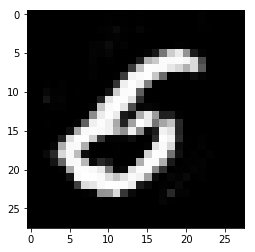

Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.7201


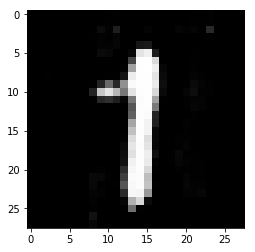

Epoch 2/2... Discriminator Loss: 2.2717... Generator Loss: 0.2030


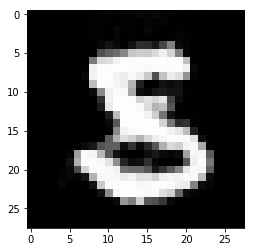

Epoch 2/2... Discriminator Loss: 1.6383... Generator Loss: 0.4135


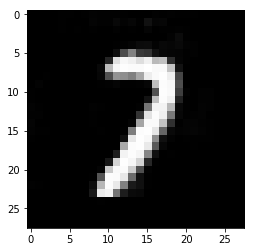

Epoch 2/2... Discriminator Loss: 1.6130... Generator Loss: 0.3953


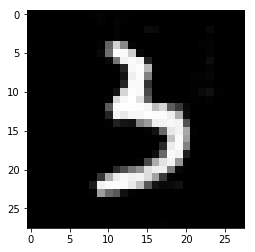

Epoch 2/2... Discriminator Loss: 1.7222... Generator Loss: 0.3464


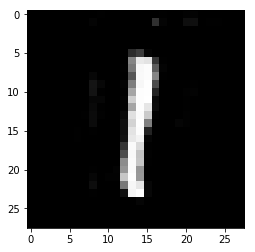

Epoch 2/2... Discriminator Loss: 1.6247... Generator Loss: 0.4384


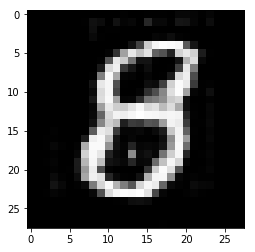

Epoch 2/2... Discriminator Loss: 1.5870... Generator Loss: 0.4140


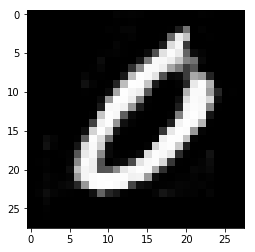

Epoch 2/2... Discriminator Loss: 1.8977... Generator Loss: 0.3050


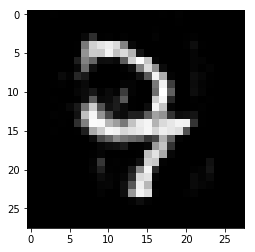

Epoch 2/2... Discriminator Loss: 2.3664... Generator Loss: 0.1888


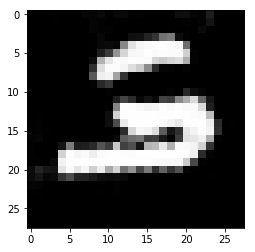

Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 0.8459


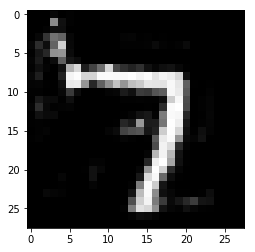

Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.9468


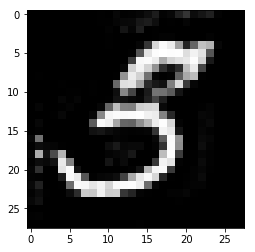

Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.6562


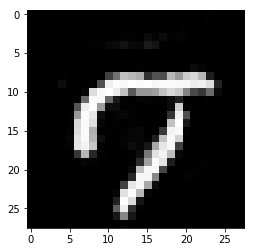

Epoch 2/2... Discriminator Loss: 1.6324... Generator Loss: 0.4121


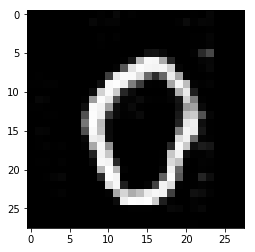

Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 1.8751


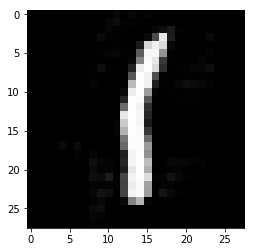

Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.6041


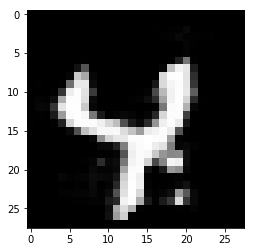

Epoch 2/2... Discriminator Loss: 1.7012... Generator Loss: 0.3802


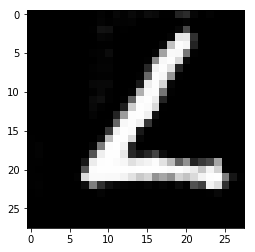

Epoch 2/2... Discriminator Loss: 1.5387... Generator Loss: 0.4529


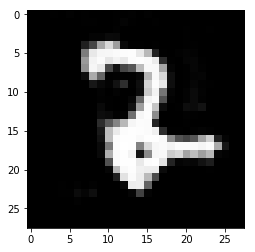

Epoch 2/2... Discriminator Loss: 1.9530... Generator Loss: 0.2813


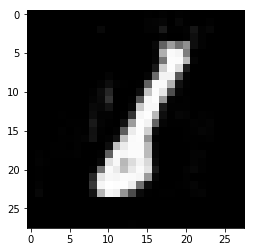

Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 0.7773


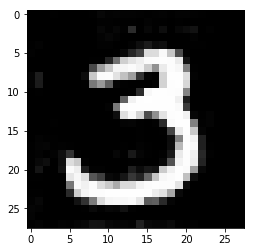

Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 1.5052


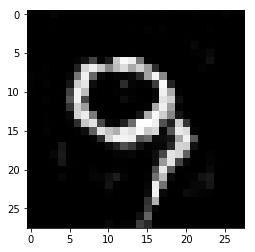

Epoch 2/2... Discriminator Loss: 1.1790... Generator Loss: 1.1470


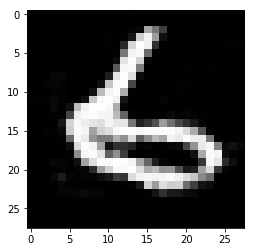

Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.6328


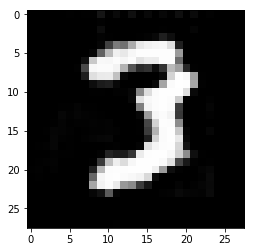

Epoch 2/2... Discriminator Loss: 1.6733... Generator Loss: 0.3714


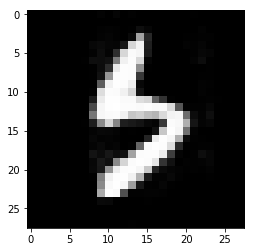

Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.5963


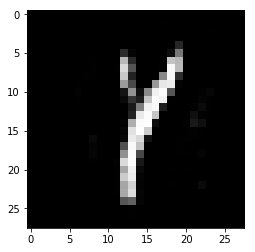

Epoch 2/2... Discriminator Loss: 1.8661... Generator Loss: 0.3038


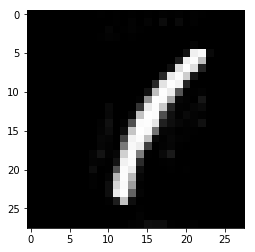

Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.8342


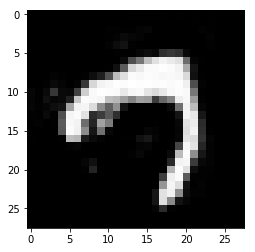

Epoch 2/2... Discriminator Loss: 1.9469... Generator Loss: 0.2857


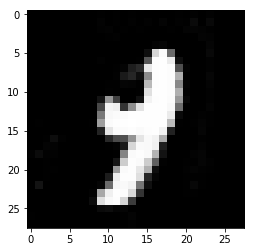

Epoch 2/2... Discriminator Loss: 1.6311... Generator Loss: 0.3985


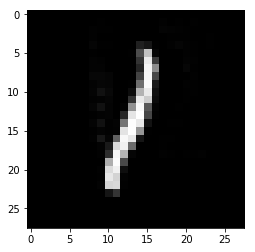

Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 1.4529


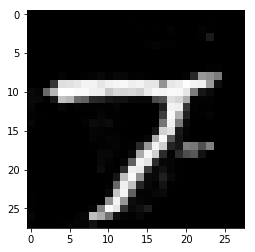

Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.5377


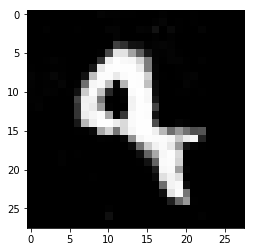

Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.8436


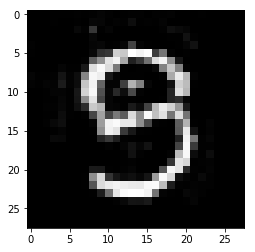

Epoch 2/2... Discriminator Loss: 1.4828... Generator Loss: 2.2629


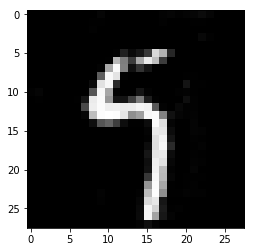

Epoch 2/2... Discriminator Loss: 1.1131... Generator Loss: 1.0243


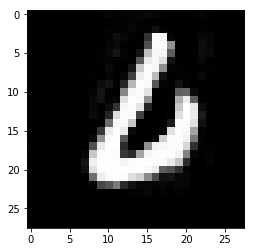

Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.3229


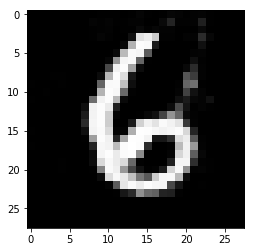

Epoch 2/2... Discriminator Loss: 1.9882... Generator Loss: 0.2700


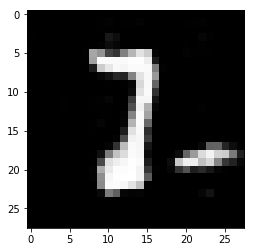

Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.5089


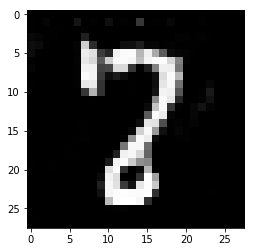

Epoch 2/2... Discriminator Loss: 1.5805... Generator Loss: 0.4021


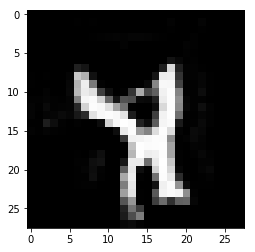

Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 1.3856


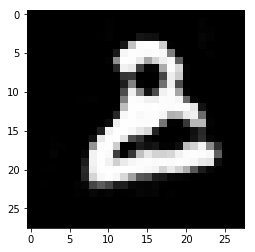

Epoch 2/2... Discriminator Loss: 1.5144... Generator Loss: 0.4552


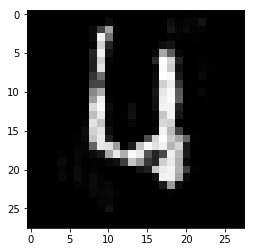

Epoch 2/2... Discriminator Loss: 2.0447... Generator Loss: 0.2526


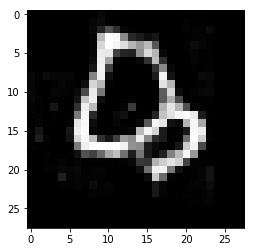

Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.6673


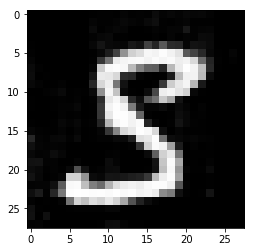

Epoch 2/2... Discriminator Loss: 1.2944... Generator Loss: 0.6349


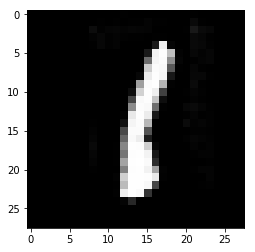

Epoch 2/2... Discriminator Loss: 1.8381... Generator Loss: 0.3220


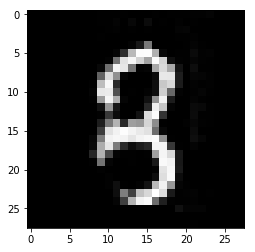

Epoch 2/2... Discriminator Loss: 1.7260... Generator Loss: 0.3376


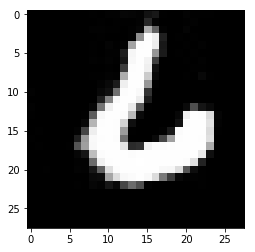

Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.7503


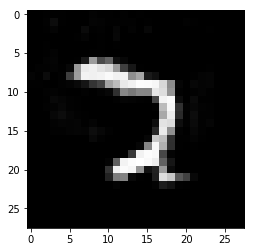

Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.5815


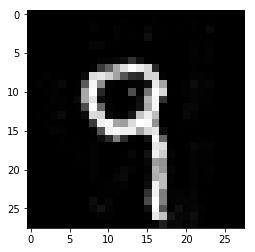

Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 0.9226


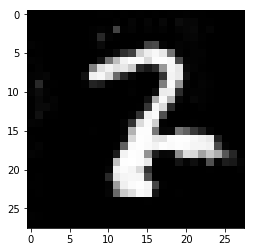

Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.6237


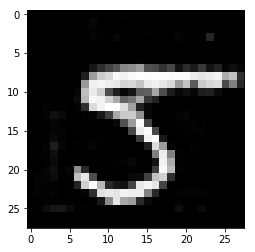

Epoch 2/2... Discriminator Loss: 1.1225... Generator Loss: 0.8318


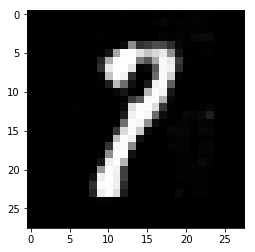

Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.5471


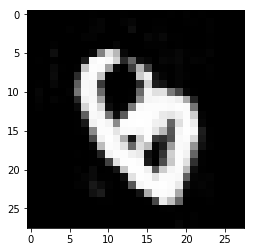

Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 1.8210


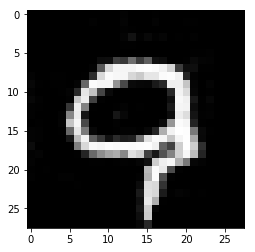

Epoch 2/2... Discriminator Loss: 2.3200... Generator Loss: 0.2041


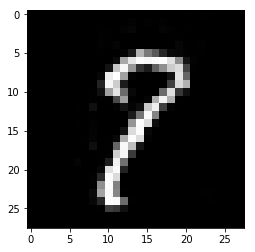

Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.6150


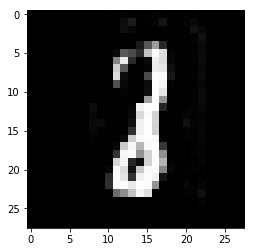

Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 0.8421


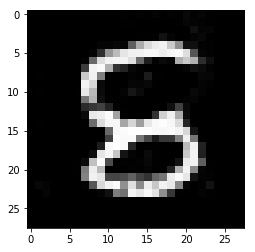

Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.9462


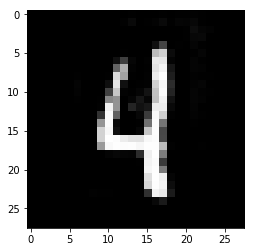

Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 0.9294


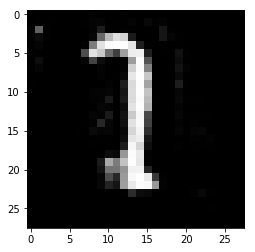

Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 1.0366


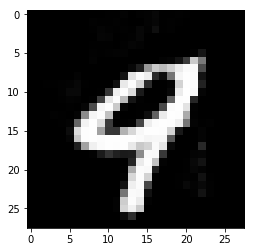

Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.7125


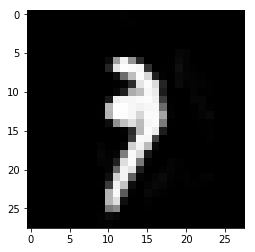

Epoch 2/2... Discriminator Loss: 1.1223... Generator Loss: 0.7994


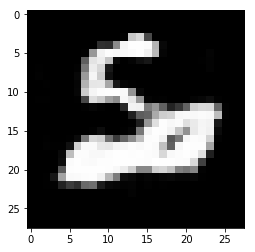

Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 1.3590


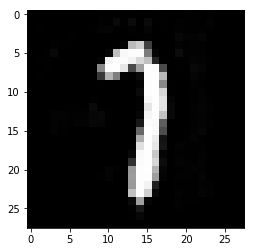

Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.5778


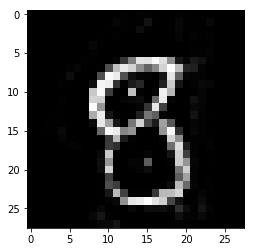

Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 0.8856


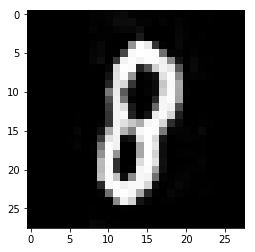

Epoch 2/2... Discriminator Loss: 1.6090... Generator Loss: 0.5219


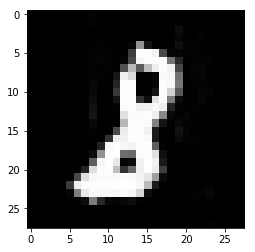

Epoch 2/2... Discriminator Loss: 1.0129... Generator Loss: 1.2227


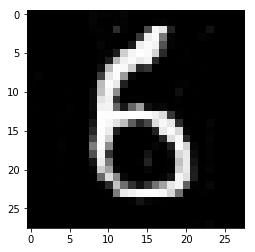

Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.5422


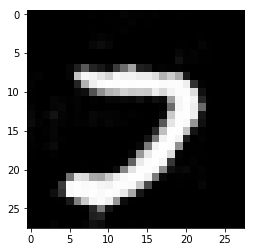

Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.9149


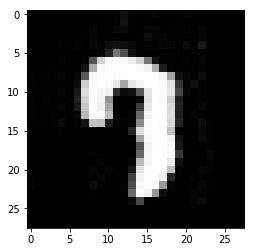

Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.4944


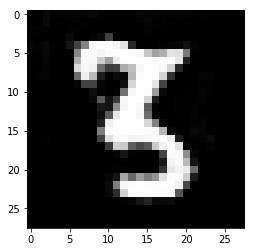

Epoch 2/2... Discriminator Loss: 1.8882... Generator Loss: 0.3450


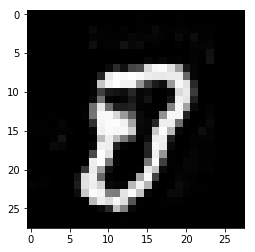

Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.8891


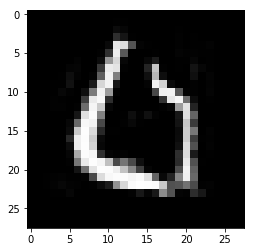

Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.9480


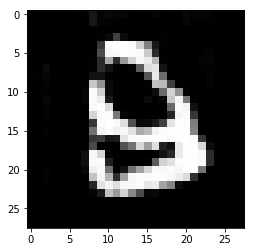

Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 1.7789


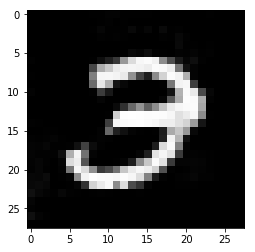

Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 1.9341


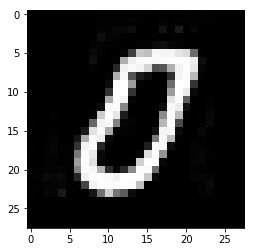

Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 0.7784


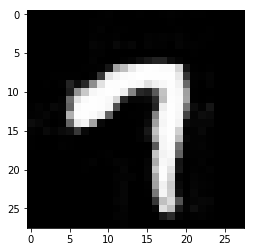

Epoch 2/2... Discriminator Loss: 1.6812... Generator Loss: 0.3749


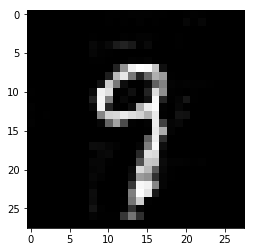

Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.8202


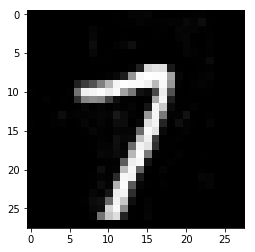

In [49]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005 #learning rate between 0.0002 and 0.0008
beta1 = 0.3 #Beta1 between 0.2 and 0.5 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 2.9686


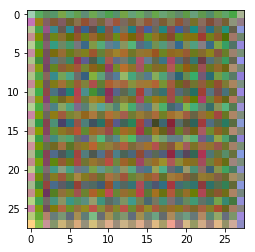

Epoch 1/1... Discriminator Loss: 2.0260... Generator Loss: 1.2081


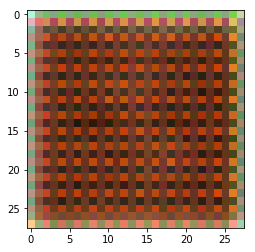

Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.1518


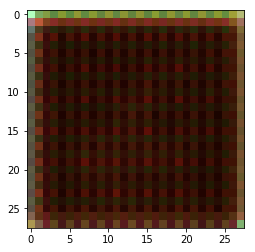

Epoch 1/1... Discriminator Loss: 2.4913... Generator Loss: 0.1855


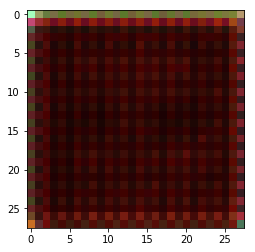

Epoch 1/1... Discriminator Loss: 2.1467... Generator Loss: 0.2205


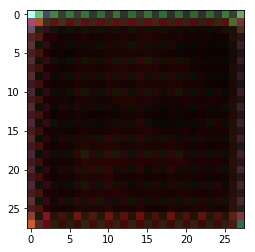

Epoch 1/1... Discriminator Loss: 2.0282... Generator Loss: 0.2754


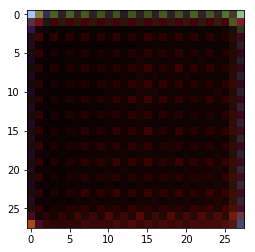

Epoch 1/1... Discriminator Loss: 2.1082... Generator Loss: 0.2387


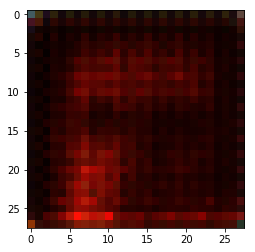

Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.4390


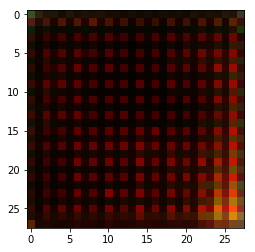

Epoch 1/1... Discriminator Loss: 2.2911... Generator Loss: 0.2130


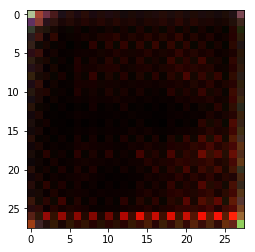

Epoch 1/1... Discriminator Loss: 1.9089... Generator Loss: 0.4450


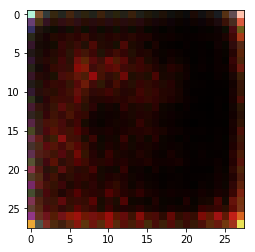

Epoch 1/1... Discriminator Loss: 2.4671... Generator Loss: 0.1508


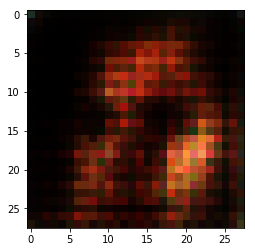

Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.9096


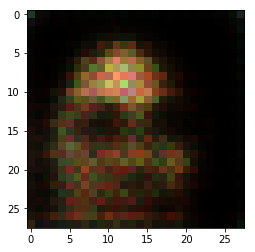

Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.8450


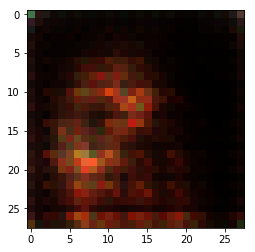

Epoch 1/1... Discriminator Loss: 2.8213... Generator Loss: 0.1036


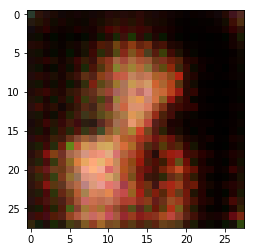

Epoch 1/1... Discriminator Loss: 1.8910... Generator Loss: 0.3077


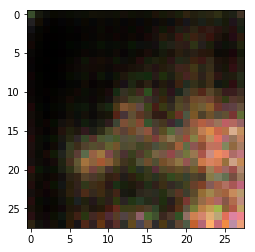

Epoch 1/1... Discriminator Loss: 1.7043... Generator Loss: 0.5827


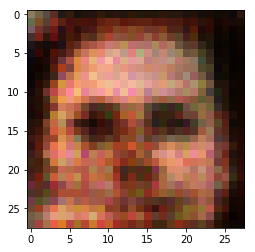

Epoch 1/1... Discriminator Loss: 1.8010... Generator Loss: 0.3415


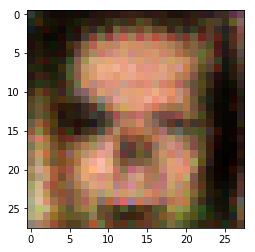

Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.3737


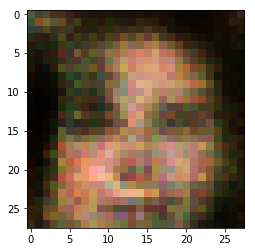

Epoch 1/1... Discriminator Loss: 1.8786... Generator Loss: 0.3286


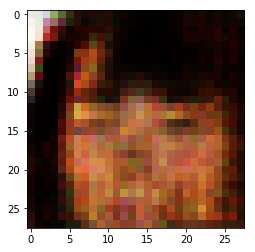

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.9388


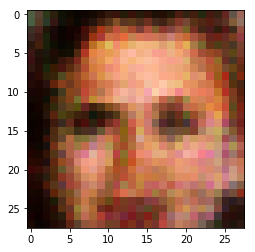

Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.4770


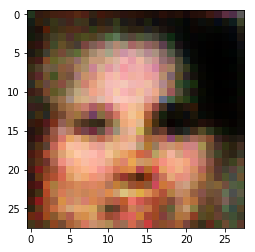

Epoch 1/1... Discriminator Loss: 1.9039... Generator Loss: 0.3181


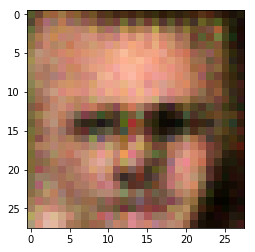

Epoch 1/1... Discriminator Loss: 1.7078... Generator Loss: 0.5282


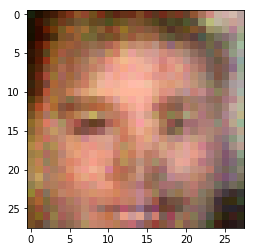

Epoch 1/1... Discriminator Loss: 1.7615... Generator Loss: 0.4888


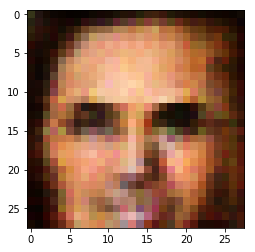

Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.5884


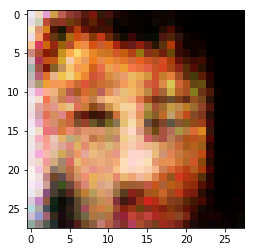

Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.8478


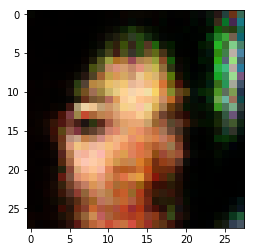

Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.6022


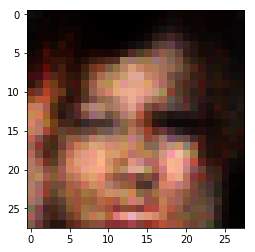

Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.7089


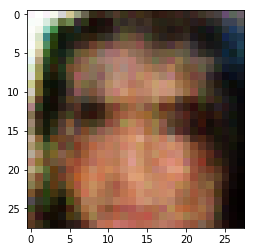

Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.4042


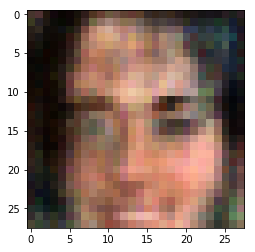

Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.5983


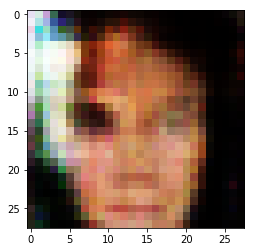

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7190


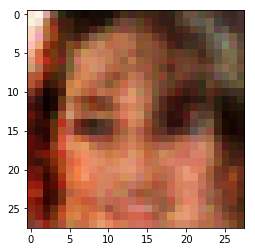

Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6354


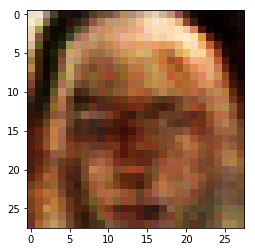

Epoch 1/1... Discriminator Loss: 1.7974... Generator Loss: 0.3303


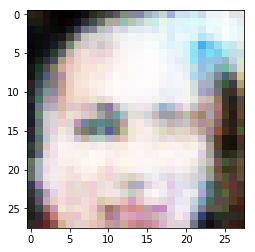

Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.9712


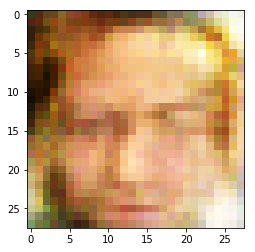

Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6872


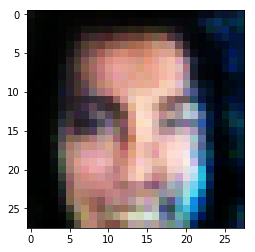

Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.6486


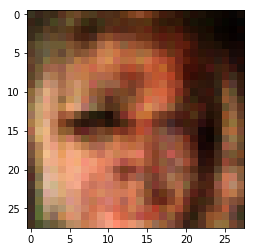

Epoch 1/1... Discriminator Loss: 1.7083... Generator Loss: 0.3688


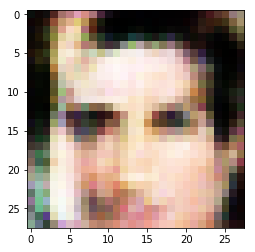

Epoch 1/1... Discriminator Loss: 1.9153... Generator Loss: 1.3852


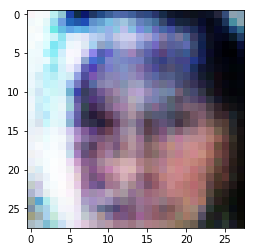

Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.4701


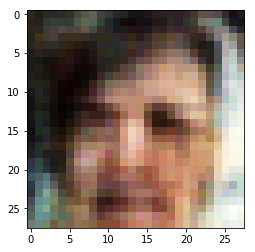

Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 1.0997


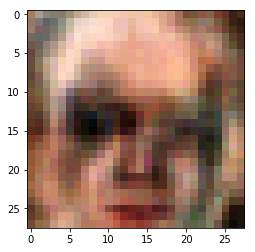

Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6913


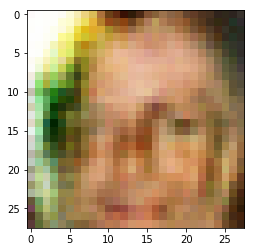

Epoch 1/1... Discriminator Loss: 1.6989... Generator Loss: 0.4247


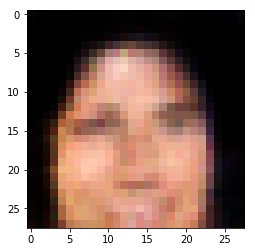

Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.5412


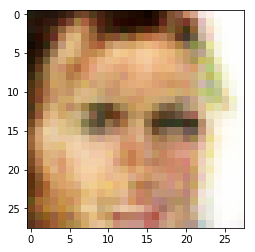

Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7873


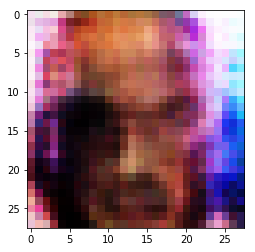

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7175


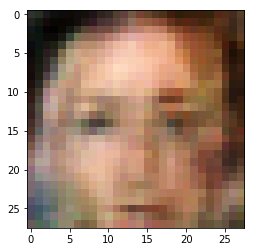

Epoch 1/1... Discriminator Loss: 2.1726... Generator Loss: 0.1915


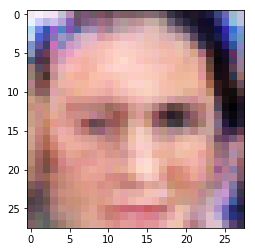

Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 0.5595


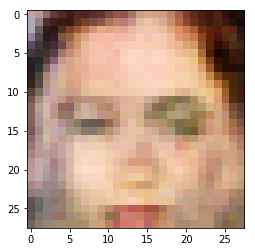

Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.7992


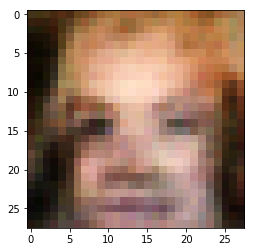

Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.9471


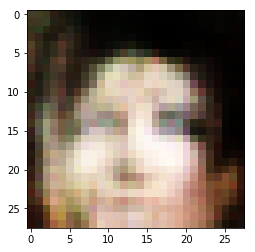

Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.4775


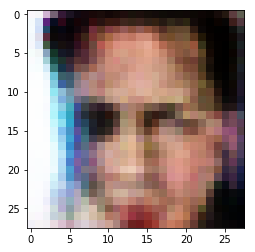

Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 1.2481


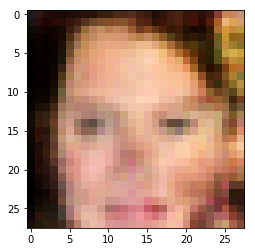

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.8718


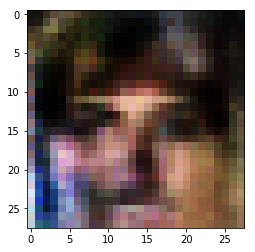

Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6305


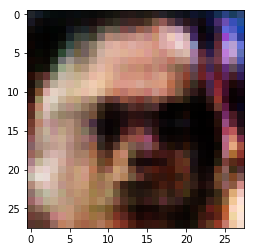

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8839


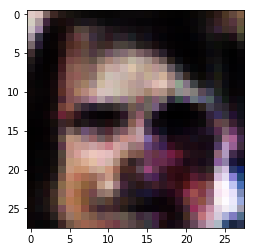

Epoch 1/1... Discriminator Loss: 1.6529... Generator Loss: 2.2087


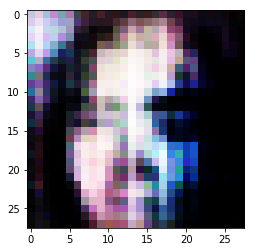

Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6750


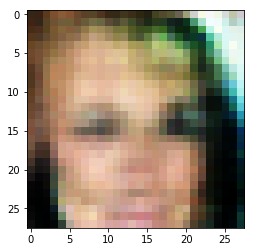

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5150


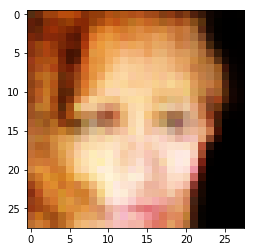

Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.1278


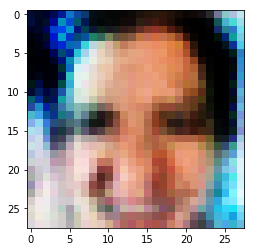

Epoch 1/1... Discriminator Loss: 3.2228... Generator Loss: 2.5710


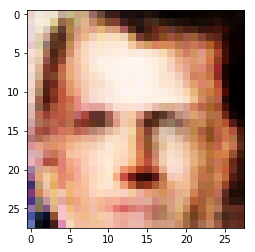

Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 1.0883


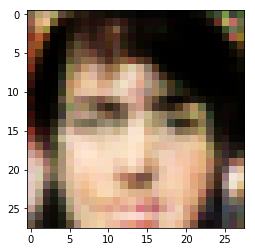

Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 1.2663


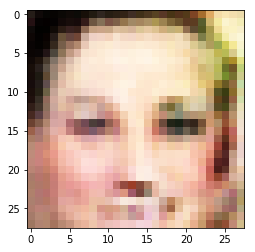

Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 1.8029


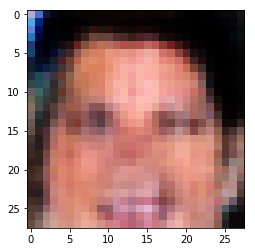

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.1694


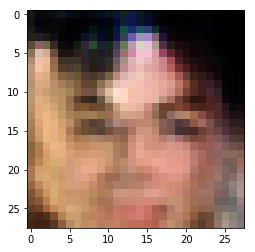

Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8626


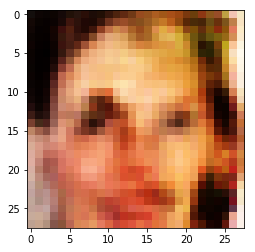

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.5303


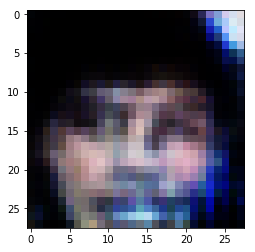

Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.5704


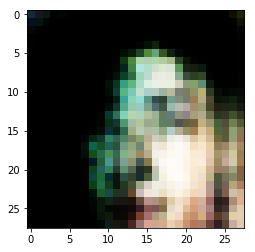

Epoch 1/1... Discriminator Loss: 1.8031... Generator Loss: 0.4417


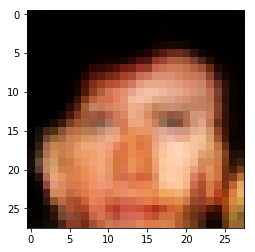

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5963


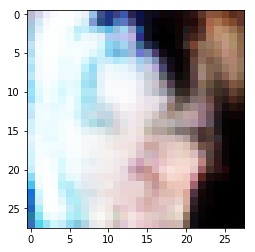

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6551


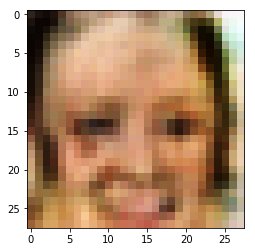

Epoch 1/1... Discriminator Loss: 1.8936... Generator Loss: 0.2497


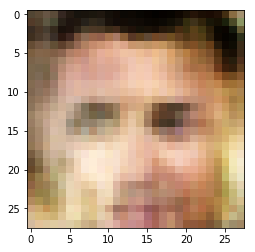

Epoch 1/1... Discriminator Loss: 1.7257... Generator Loss: 0.4430


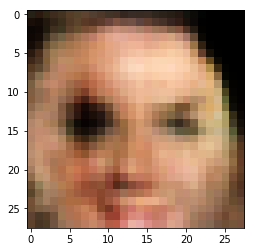

Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7150


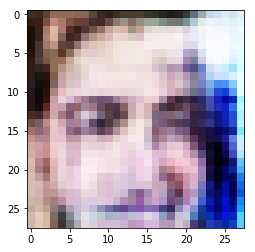

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.8624


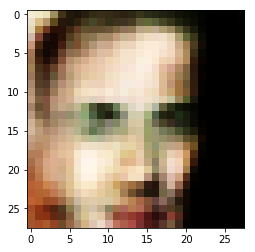

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.4503


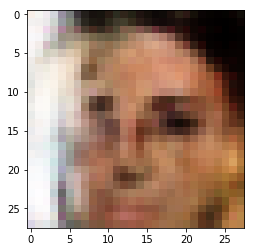

Epoch 1/1... Discriminator Loss: 1.5866... Generator Loss: 0.3953


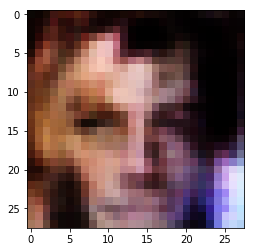

Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.3551


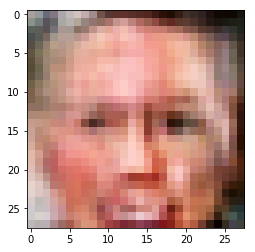

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8965


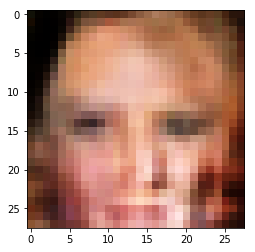

Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 1.6319


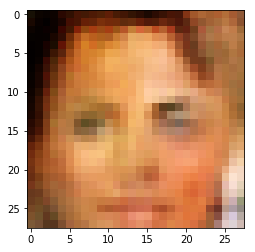

Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 0.3253


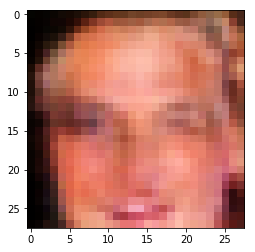

Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.4788


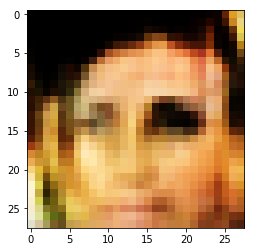

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.7729


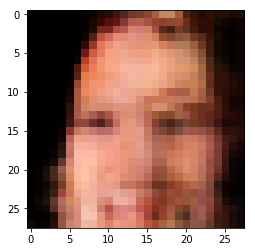

Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.6534


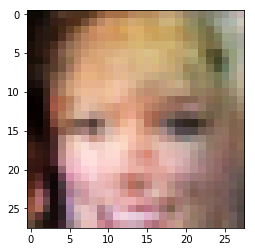

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8956


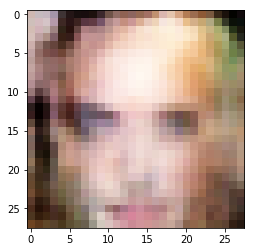

Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7268


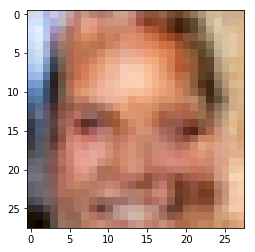

Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8709


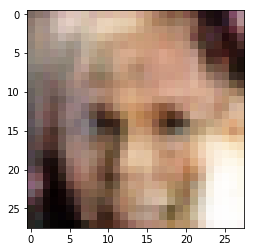

Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0513


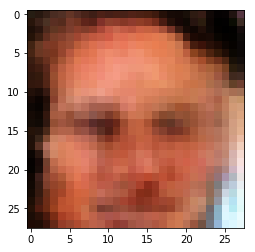

Epoch 1/1... Discriminator Loss: 1.6364... Generator Loss: 0.3700


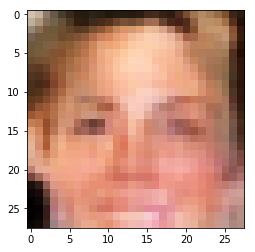

Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6761


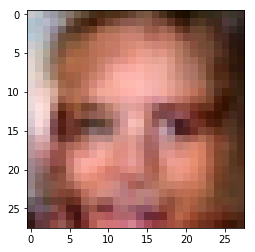

Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7297


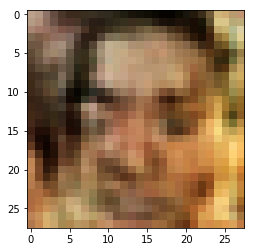

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8283


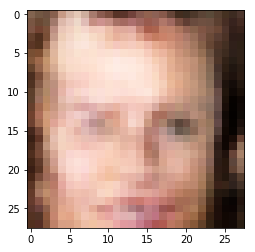

Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.8501


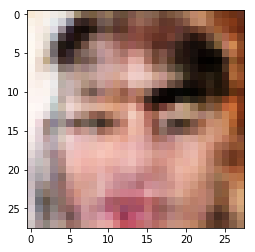

Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6894


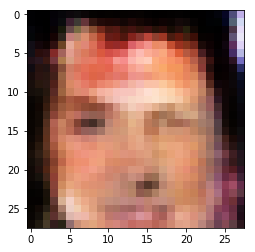

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.9053


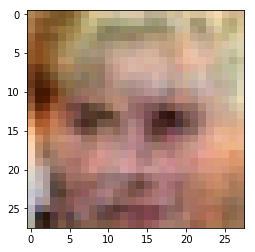

Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.7023


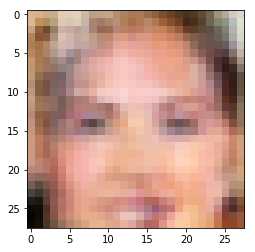

Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.5908


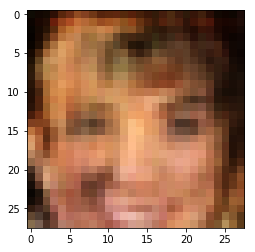

Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.7803


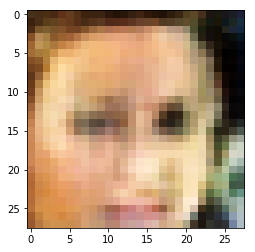

Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.5064


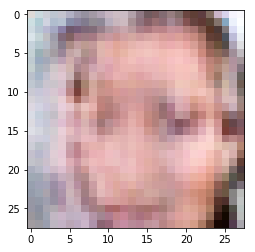

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8448


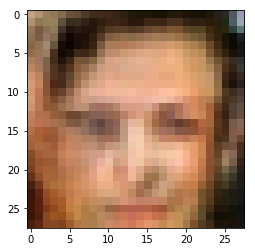

Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6944


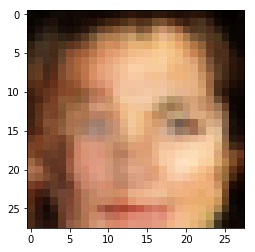

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7217


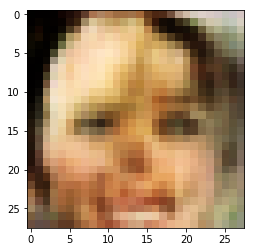

Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6310


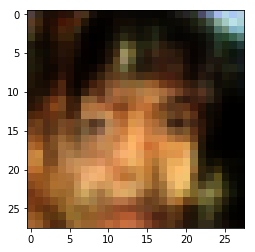

Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5794


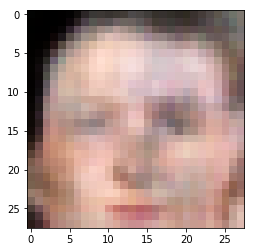

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8073


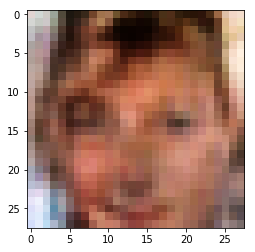

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.5143


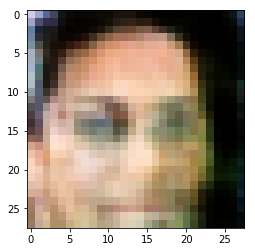

Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.4205


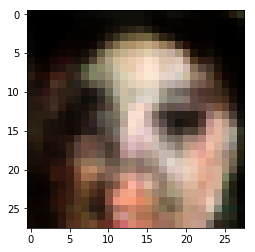

Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.6423


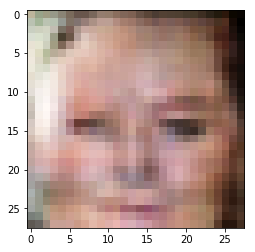

Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 1.1271


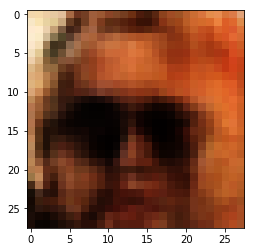

Epoch 1/1... Discriminator Loss: 2.2284... Generator Loss: 0.1878


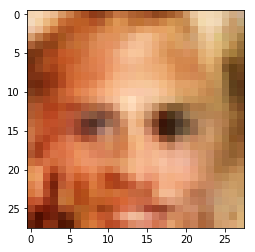

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 1.1112


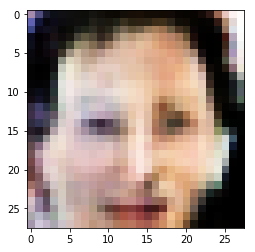

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7021


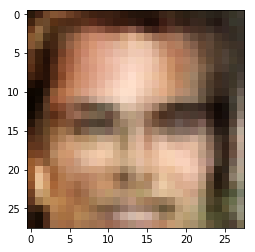

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5529


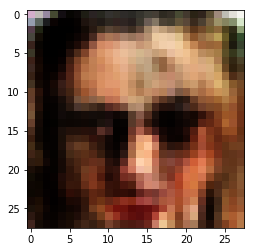

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.8915


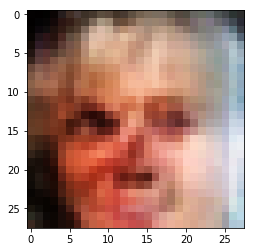

Epoch 1/1... Discriminator Loss: 1.8503... Generator Loss: 0.5660


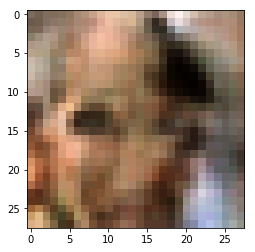

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6618


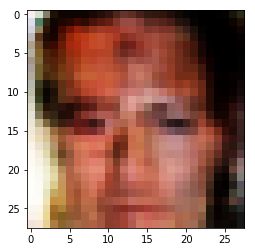

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.9191


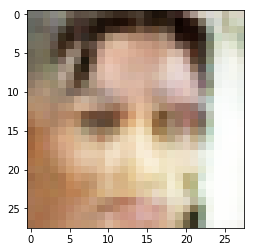

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8217


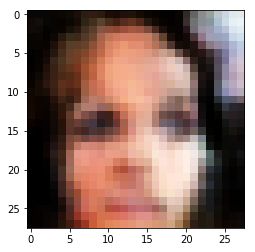

Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.8223


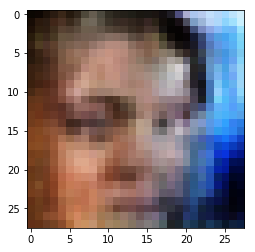

Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.9227


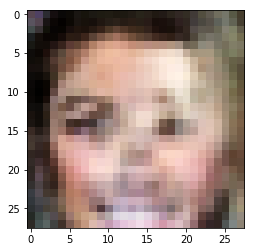

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7803


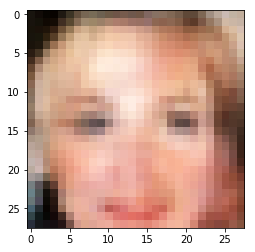

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6212


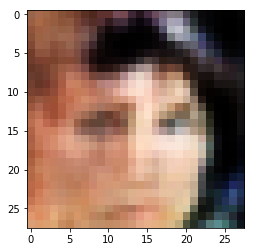

Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.9928


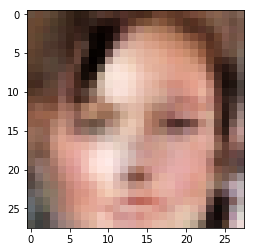

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 1.1199


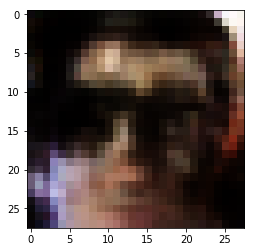

Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5831


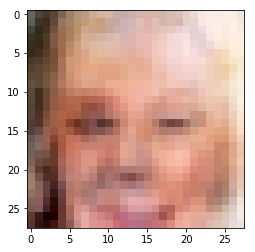

Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.4135


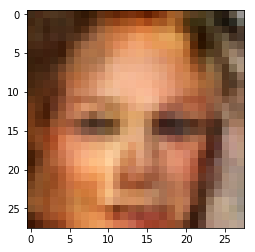

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.1335


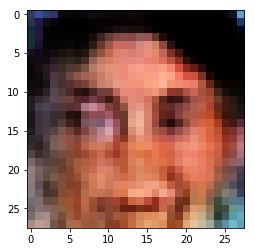

Epoch 1/1... Discriminator Loss: 2.0992... Generator Loss: 0.3075


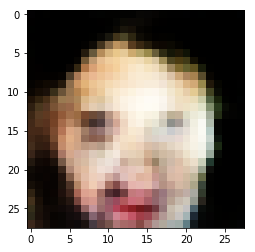

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7003


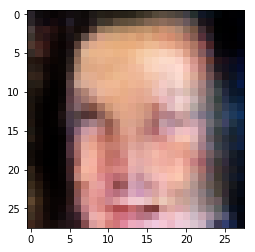

Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.4957


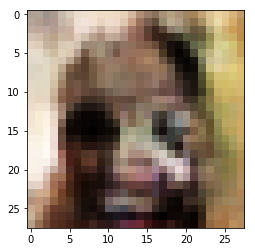

Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.3374


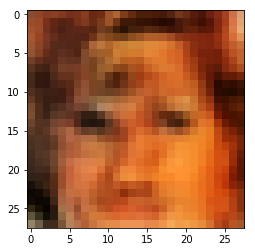

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5413


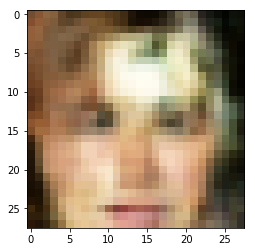

Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8706


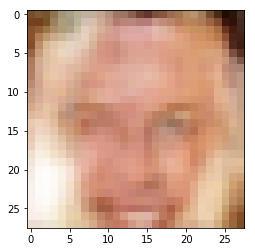

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6937


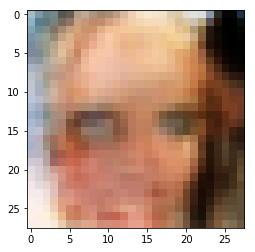

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.4910


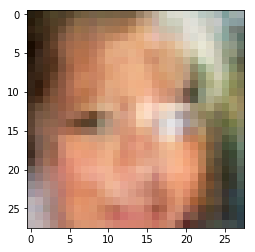

Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.4493


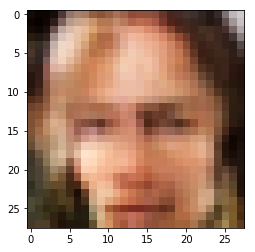

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.9281


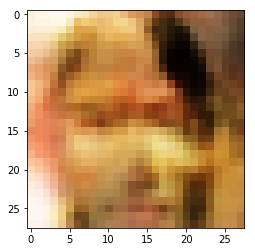

Epoch 1/1... Discriminator Loss: 1.7589... Generator Loss: 0.4982


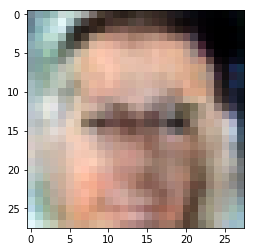

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5559


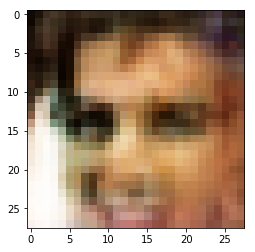

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6696


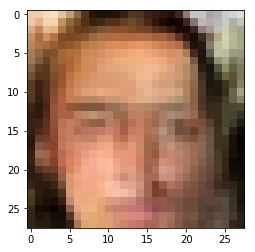

Epoch 1/1... Discriminator Loss: 1.6184... Generator Loss: 1.6660


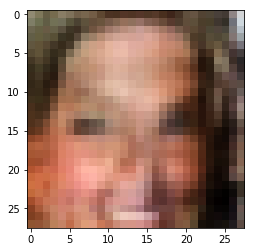

Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6680


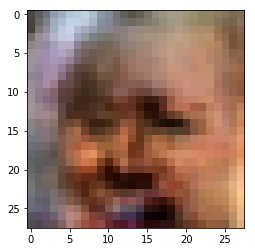

Epoch 1/1... Discriminator Loss: 2.0989... Generator Loss: 0.2412


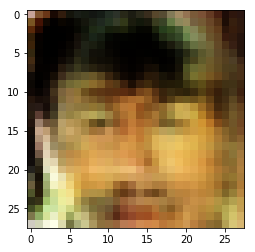

Epoch 1/1... Discriminator Loss: 2.4060... Generator Loss: 0.1697


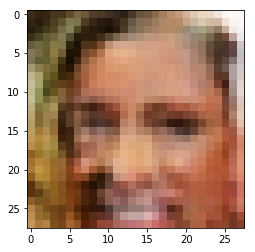

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6802


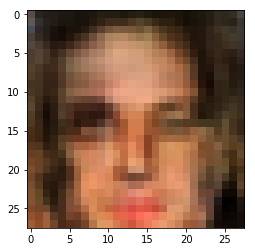

Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.5274


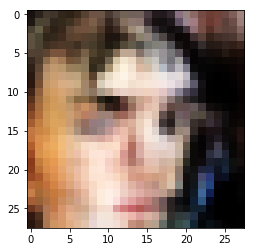

Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.5437


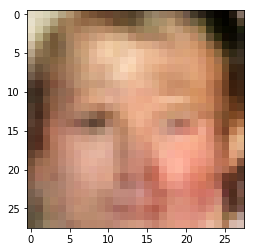

Epoch 1/1... Discriminator Loss: 1.5208... Generator Loss: 0.6009


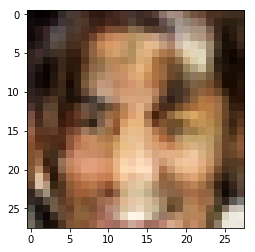

Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7742


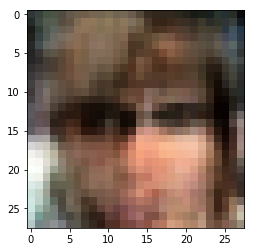

Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6583


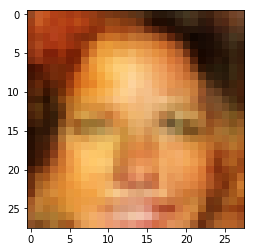

Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8065


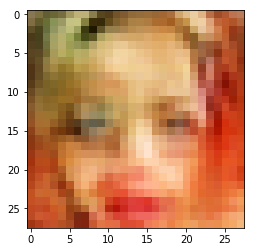

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6271


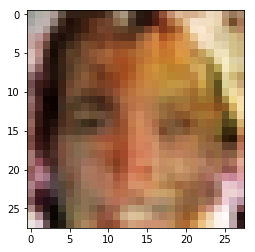

Epoch 1/1... Discriminator Loss: 1.8494... Generator Loss: 0.3525


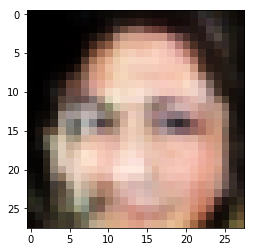

Epoch 1/1... Discriminator Loss: 1.7035... Generator Loss: 0.3958


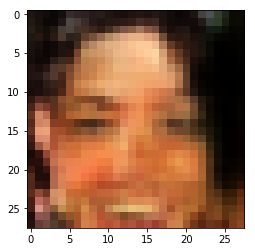

Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7749


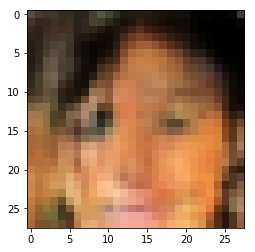

Epoch 1/1... Discriminator Loss: 2.7412... Generator Loss: 0.1047


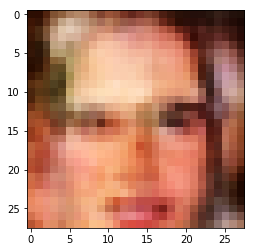

Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6530


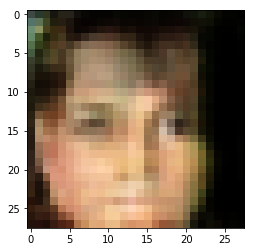

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7105


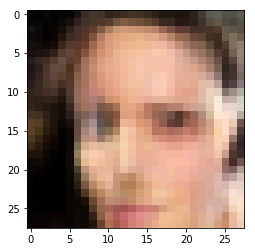

Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.9102


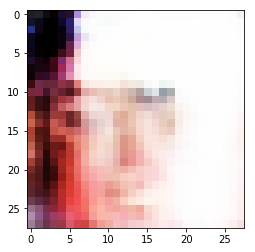

Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.6392


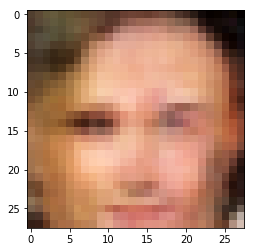

Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.7654


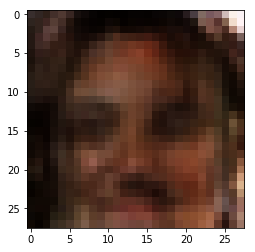

Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6737


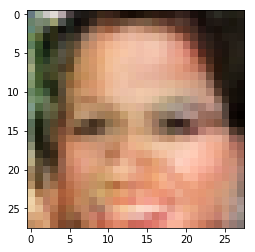

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8127


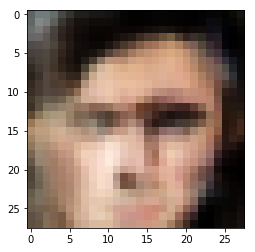

Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.4373


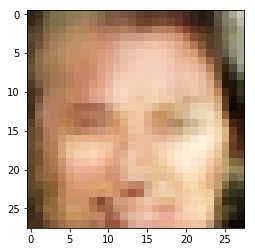

Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.4300


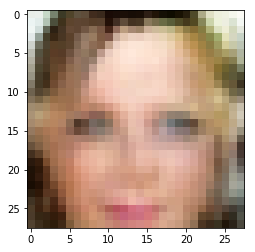

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7900


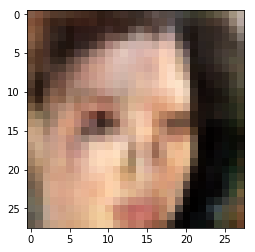

Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 1.2967


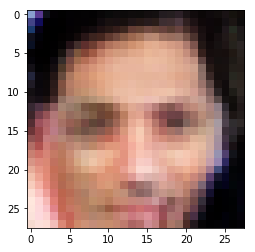

Epoch 1/1... Discriminator Loss: 1.6762... Generator Loss: 0.4015


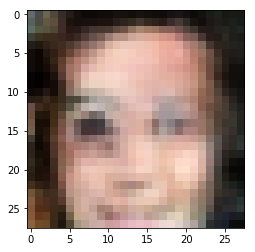

Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.5680


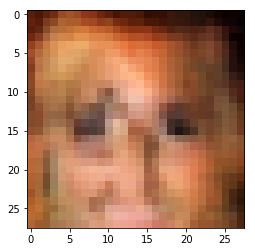

Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.5169


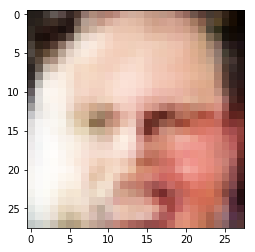

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8736


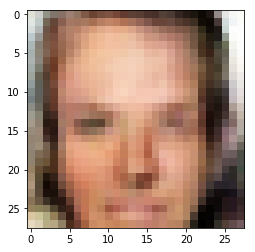

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7083


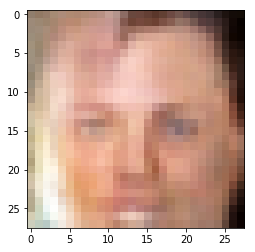

Epoch 1/1... Discriminator Loss: 2.4988... Generator Loss: 1.3594


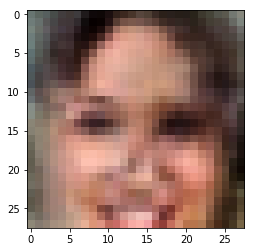

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7697


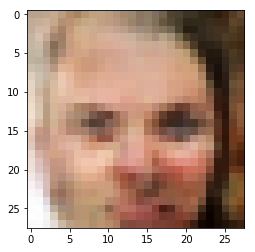

Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.7218


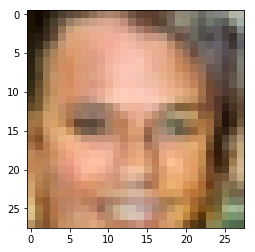

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.9153


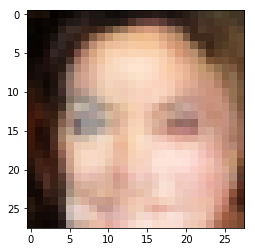

Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6206


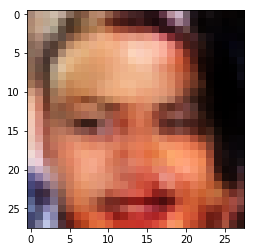

Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6302


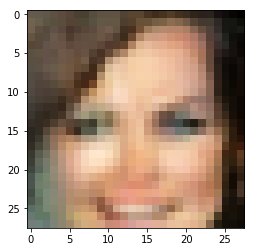

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7610


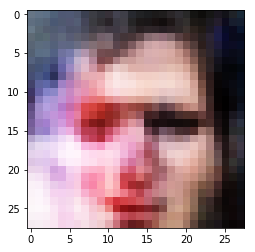

Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.4871


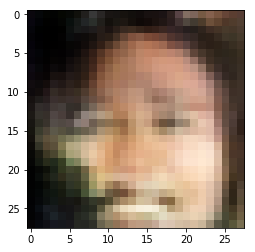

Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6450


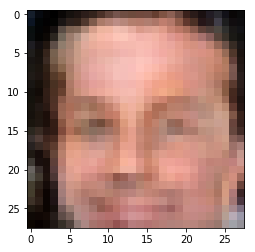

Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6087


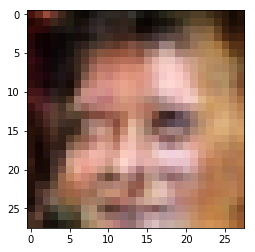

Epoch 1/1... Discriminator Loss: 2.1554... Generator Loss: 0.2580


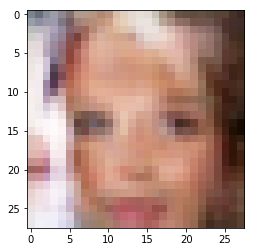

Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6246


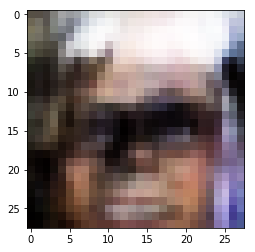

Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6330


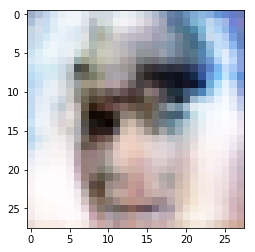

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7319


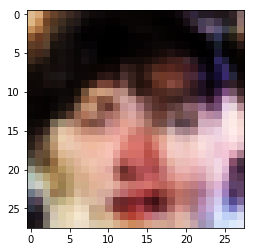

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6288


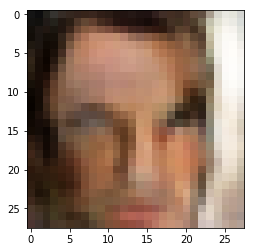

Epoch 1/1... Discriminator Loss: 1.9386... Generator Loss: 1.2825


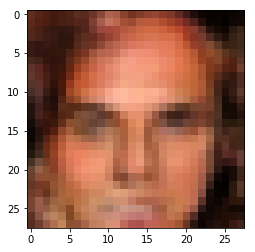

Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.5562


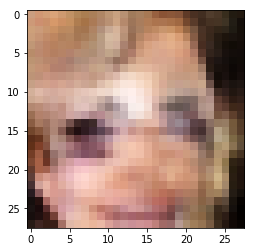

Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 1.0449


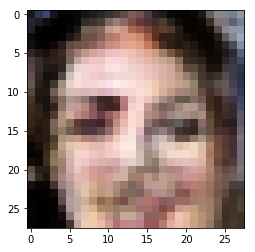

Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7270


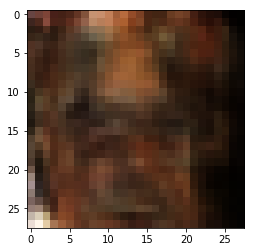

Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8191


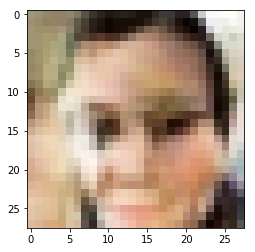

Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.4379


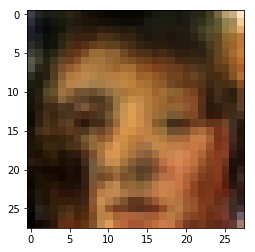

Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6174


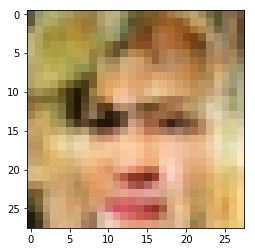

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6829


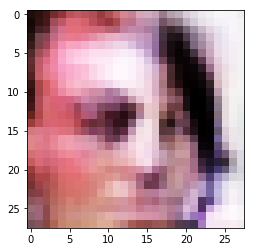

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5528


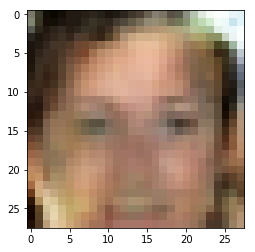

Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6277


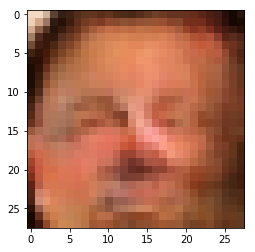

Epoch 1/1... Discriminator Loss: 1.8551... Generator Loss: 1.6227


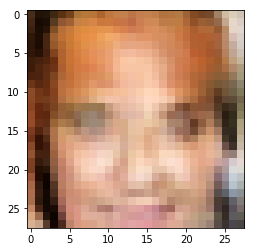

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 1.1750


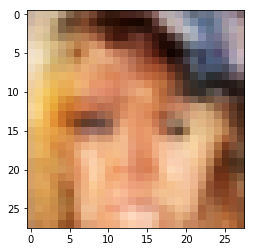

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6340


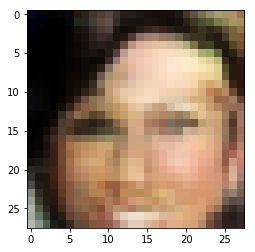

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8948


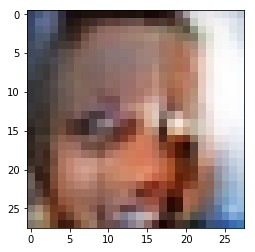

Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.5892


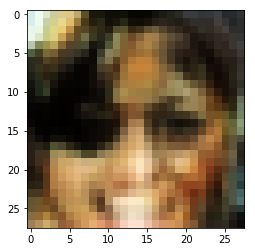

Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 1.0162


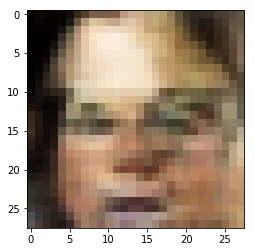

Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7053


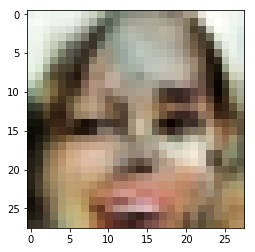

Epoch 1/1... Discriminator Loss: 1.7171... Generator Loss: 1.3099


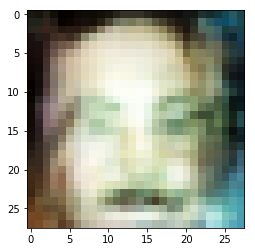

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.0635


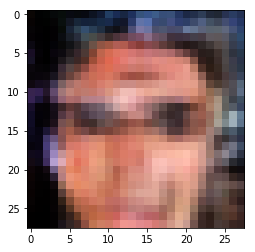

Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.3846


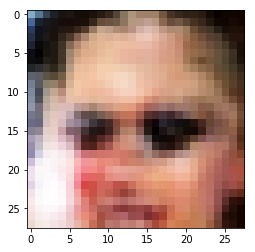

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6687


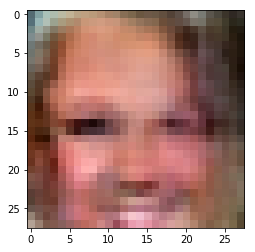

Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7447


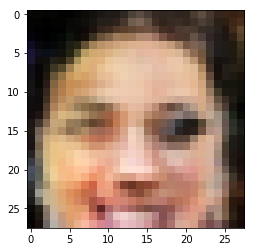

Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.6297


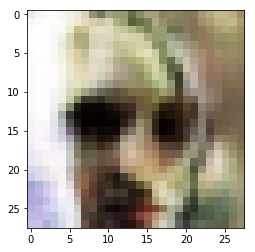

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.9170


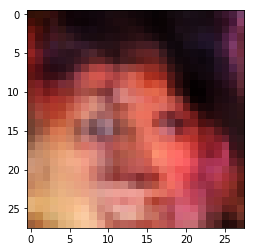

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7690


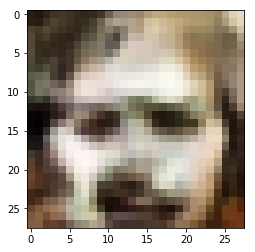

Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8782


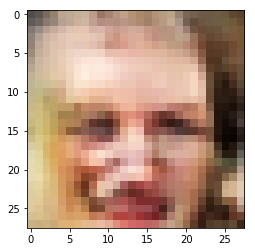

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.5916


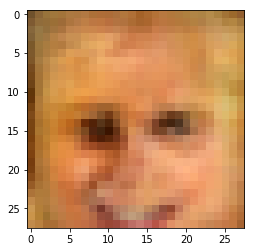

Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.5492


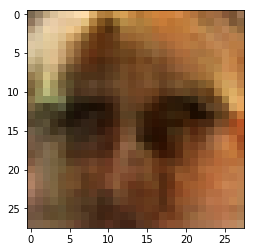

Epoch 1/1... Discriminator Loss: 3.2005... Generator Loss: 0.0895


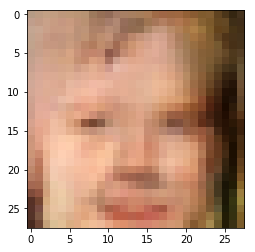

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6829


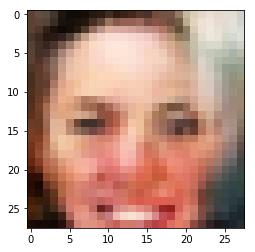

Epoch 1/1... Discriminator Loss: 1.9426... Generator Loss: 0.3181


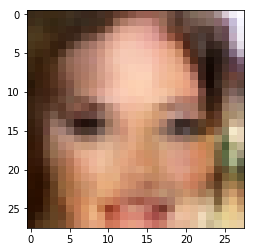

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6532


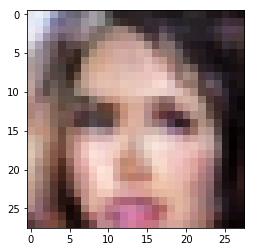

Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.8651


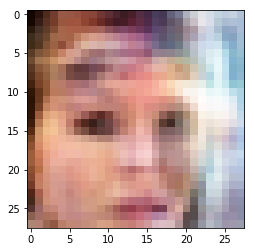

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5769


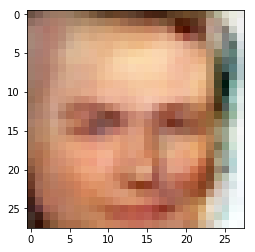

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5710


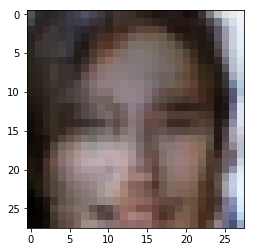

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6045


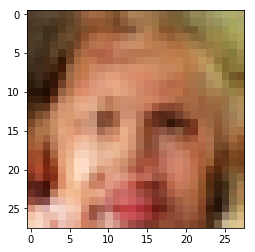

Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 1.0351


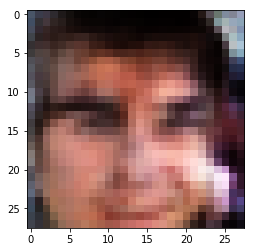

Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.7440


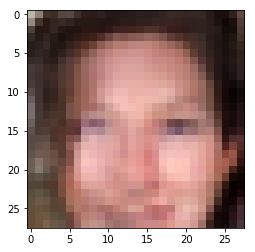

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.5787


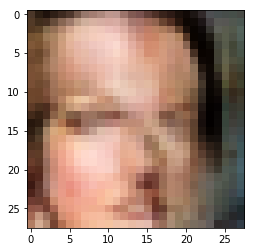

Epoch 1/1... Discriminator Loss: 1.7168... Generator Loss: 0.3926


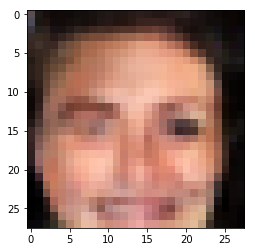

Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.5988


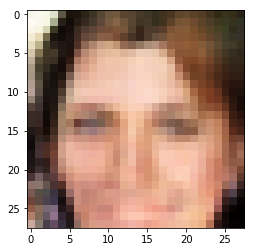

Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5875


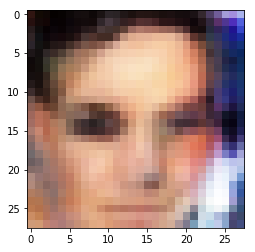

Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5684


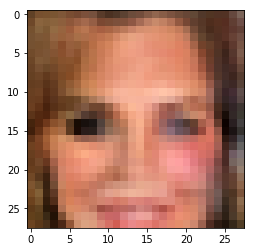

Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 1.1209


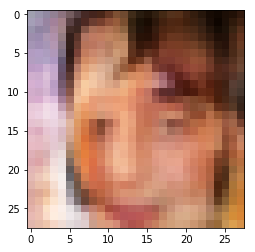

Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 0.5724


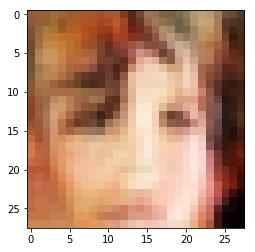

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6086


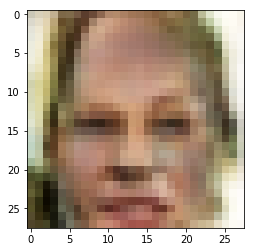

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8770


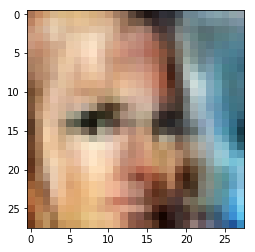

Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6566


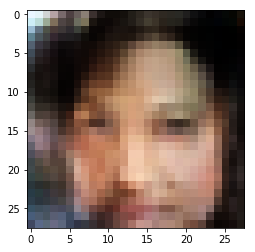

Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.5071


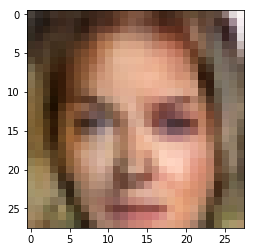

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5519


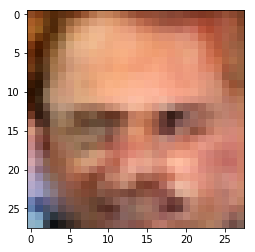

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8973


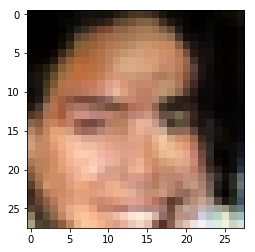

Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5099


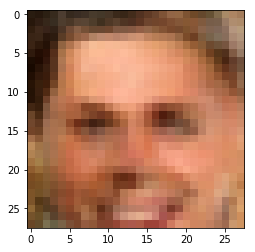

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5241


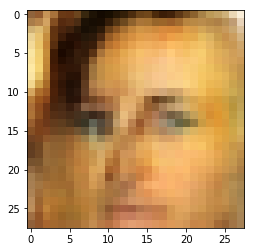

Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.9594


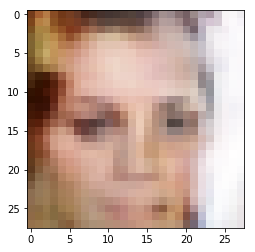

Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.4284


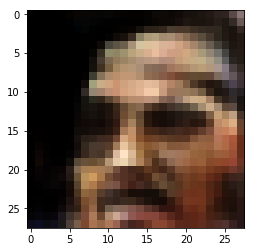

Epoch 1/1... Discriminator Loss: 1.7494... Generator Loss: 0.3463


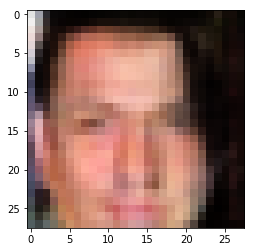

Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.5131


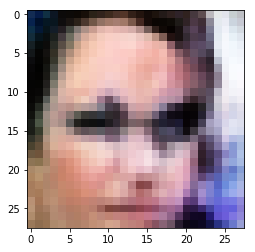

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6500


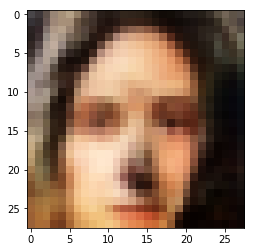

Epoch 1/1... Discriminator Loss: 2.6964... Generator Loss: 0.1449


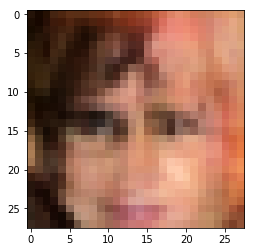

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7935


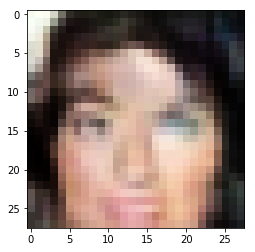

Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.4885


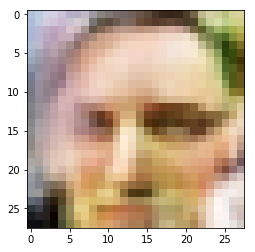

Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.4374


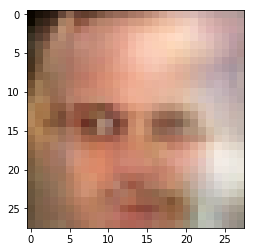

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5434


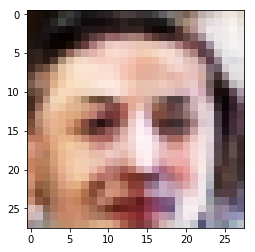

Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.4010


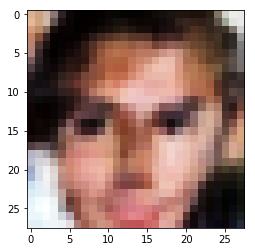

Epoch 1/1... Discriminator Loss: 1.7019... Generator Loss: 0.4311


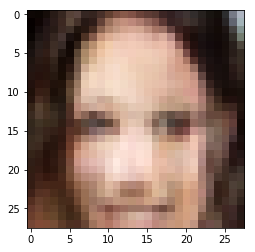

Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 1.0671


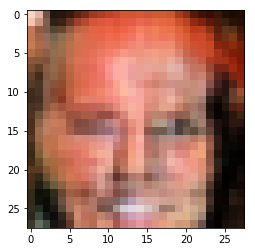

Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7465


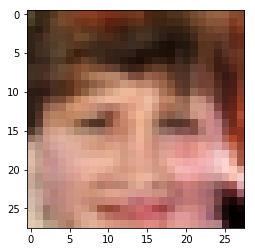

Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5820


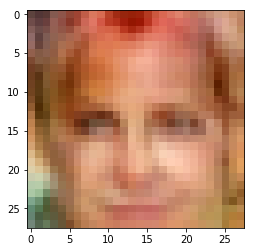

Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6509


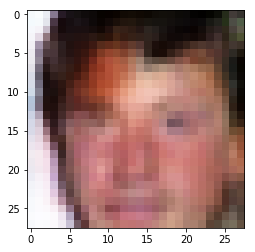

Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.7494


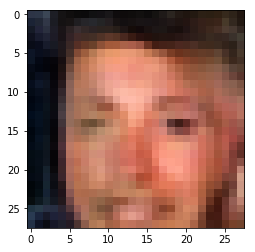

Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.5109


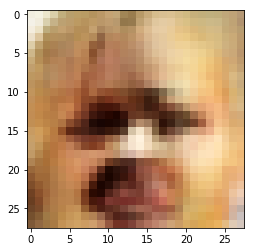

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6204


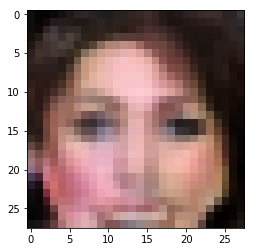

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5598


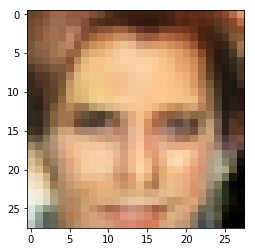

Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6410


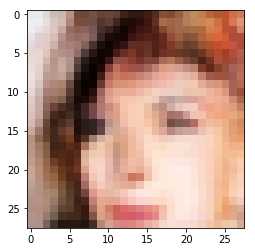

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7194


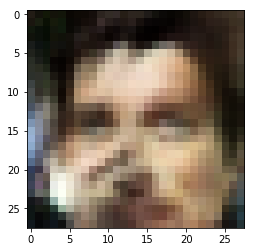

Epoch 1/1... Discriminator Loss: 1.9808... Generator Loss: 0.3338


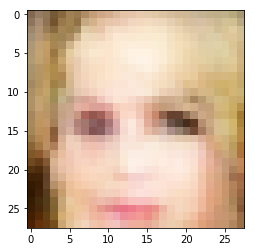

Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.7388


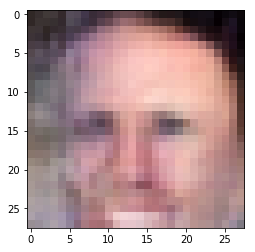

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5954


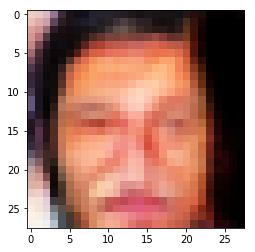

Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6533


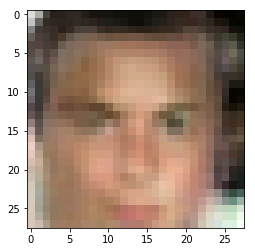

Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.4116


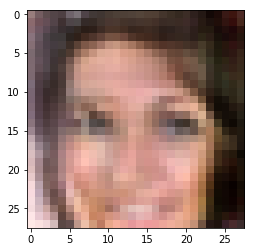

Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7786


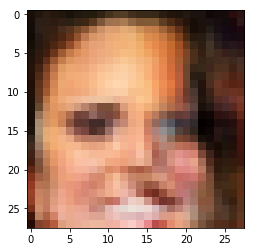

Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7866


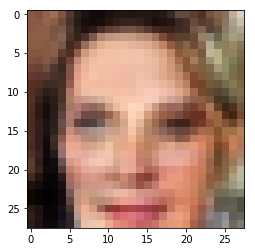

Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.4850


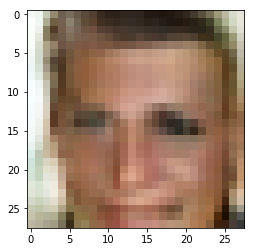

Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.9040


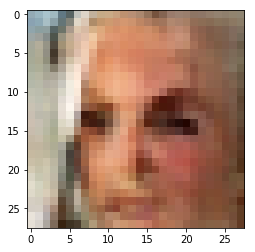

Epoch 1/1... Discriminator Loss: 1.7117... Generator Loss: 0.4238


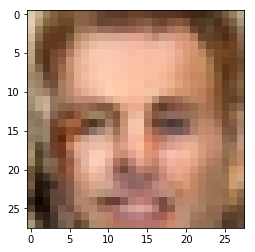

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5681


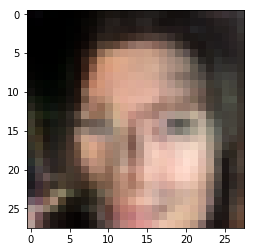

Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.4658


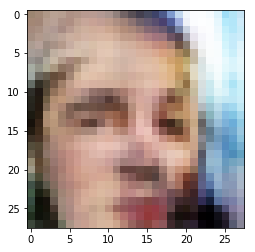

Epoch 1/1... Discriminator Loss: 2.0206... Generator Loss: 1.5484


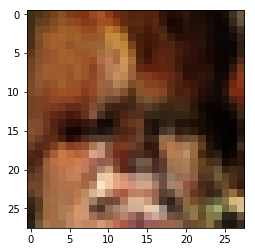

Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.6437


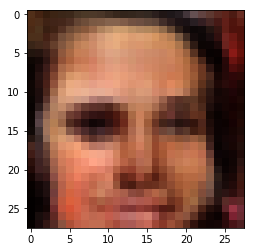

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7604


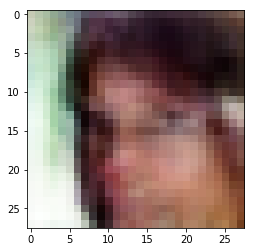

Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5577


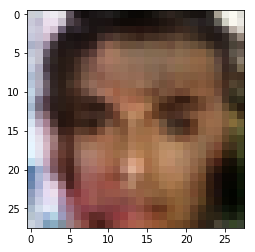

Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.5640


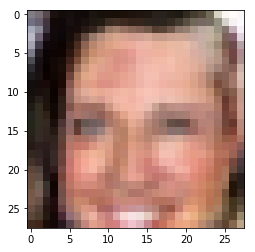

Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.5945


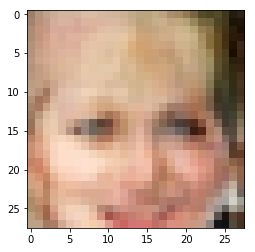

Epoch 1/1... Discriminator Loss: 1.8421... Generator Loss: 0.3697


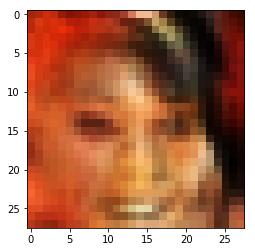

Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.5855


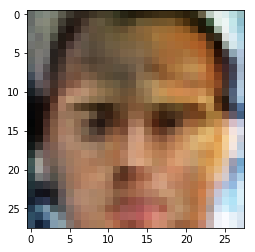

Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.6619


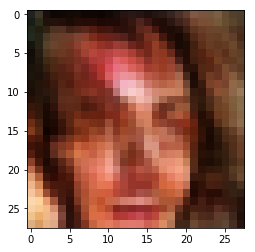

Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.9286


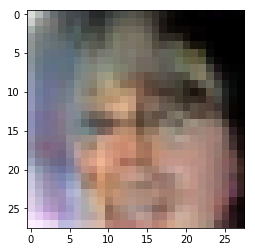

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5835


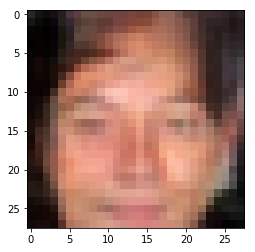

Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.7698


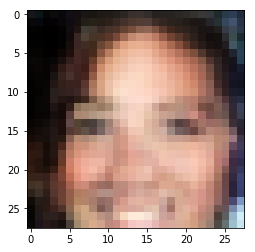

Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.5439


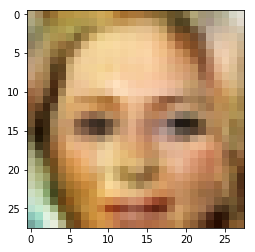

Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.4236


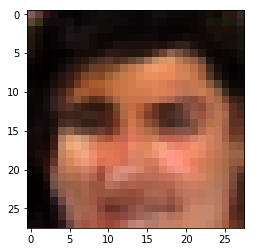

Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6789


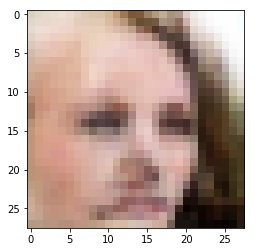

Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6411


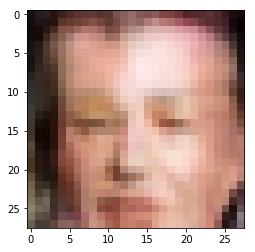

Epoch 1/1... Discriminator Loss: 3.5287... Generator Loss: 0.0524


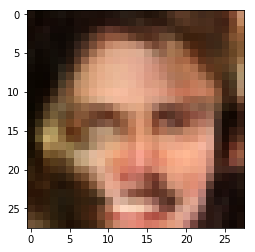

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8079


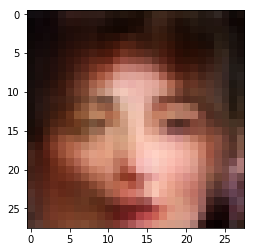

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6643


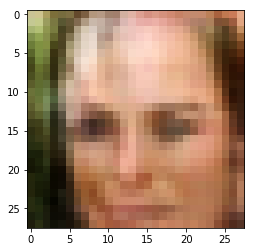

Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6489


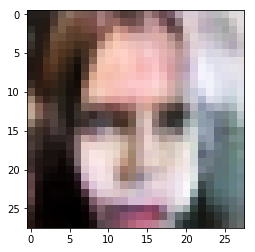

Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6884


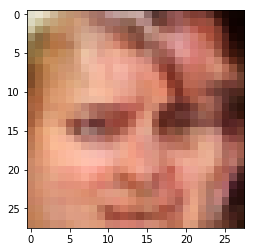

Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 0.5242


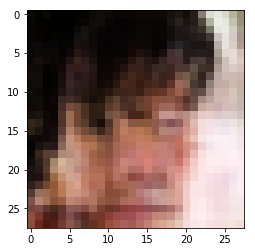

Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.9353


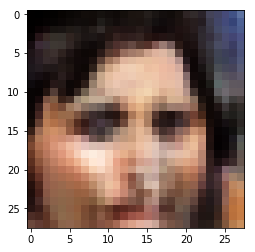

Epoch 1/1... Discriminator Loss: 2.7885... Generator Loss: 0.1626


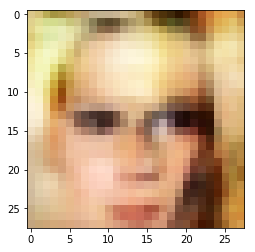

Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6577


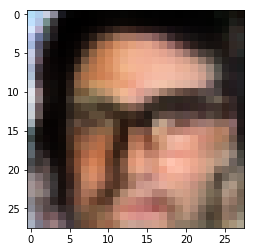

Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.3767


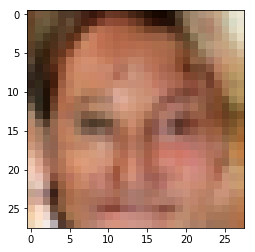

Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.2854


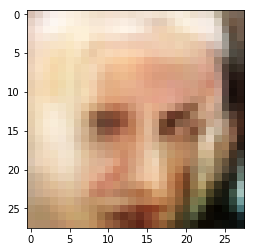

Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.5874


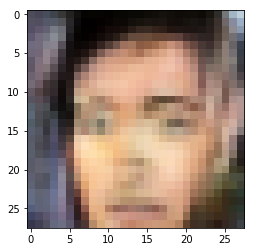

Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 0.4259


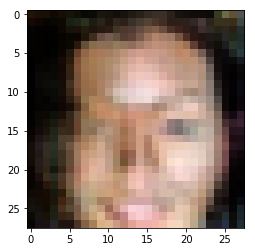

Epoch 1/1... Discriminator Loss: 2.1745... Generator Loss: 0.2606


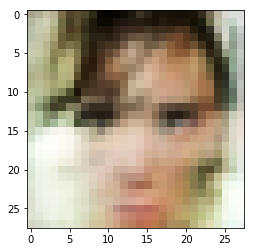

Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6078


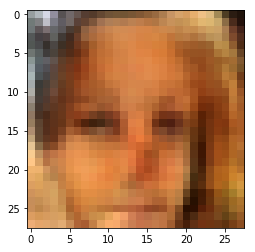

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7199


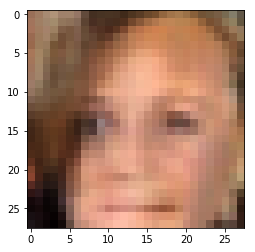

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8515


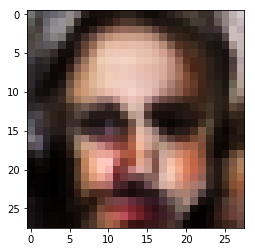

Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 0.4569


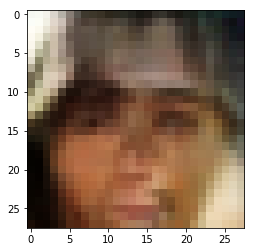

Epoch 1/1... Discriminator Loss: 1.7324... Generator Loss: 0.3346


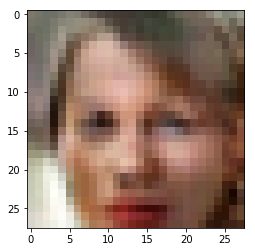

Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6578


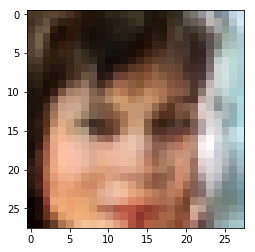

Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.4849


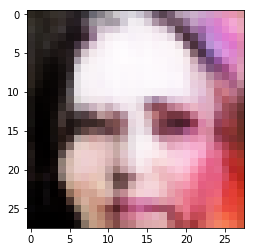

Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.8454


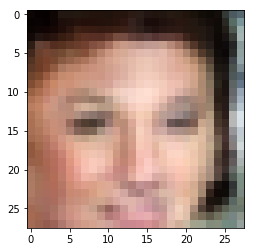

Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8342


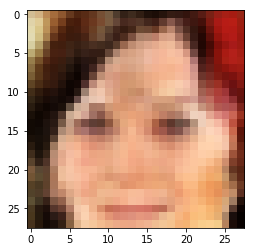

Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 1.0702


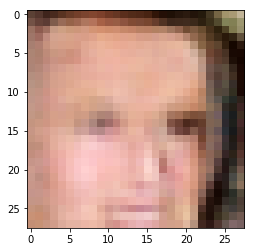

Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.6500


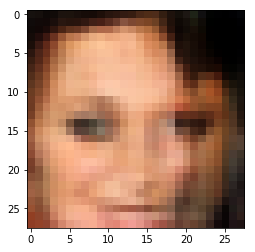

Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.5162


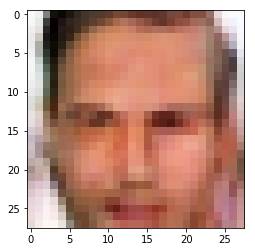

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.4516


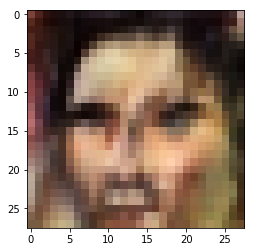

Epoch 1/1... Discriminator Loss: 1.7442... Generator Loss: 0.4861


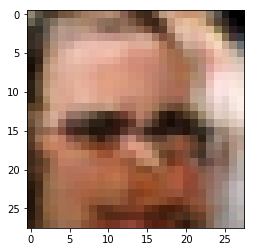

In [50]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005 #learning rate between 0.0002 and 0.0008
beta1 = 0.3 #Beta1 between 0.2 and 0.5 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.